<a href="https://colab.research.google.com/github/tousifo/ml_notebooks/blob/main/MedMNIST_QNN_AllInOne.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pennylane medmnist scikit-learn matplotlib scikit-image
!pip install shap lime

In [2]:
# =========================
# PREPROCESS
# =========================
import os, time, json, math, random
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm.auto import tqdm
from sklearn.metrics import f1_score, roc_auc_score

# Optional libs
try:
    import medmnist
    from medmnist import INFO
    print("✓ MedMNIST loaded")
except Exception as e:
    raise RuntimeError("Install medmnist first: pip install medmnist") from e

try:
    from PIL import Image
    HAVE_PIL = True
    print("✓ PIL loaded")
except:
    HAVE_PIL = False

# ---- Config
class Config:
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    CACHE_DIR = Path("medmnist_cache")              # FIX: ensure exists + use as str
    BATCH_SIZE = 64
    EPOCHS_CORE = 80
    EPOCHS_VIA  = 40
    LEARNING_RATE = 3e-4
    WEIGHT_DECAY = 1e-4
    PATIENCE = 20
    AUG_SEED = 42
    DO_CALIBRATION = False
    SNAPSHOT_ENSEMBLE = True
    SNAPSHOT_INTERVAL = 20
    CORE_DATASETS = ["BloodMNIST", "PneumoniaMNIST", "DermaMNIST"]

# FIX: create cache dir early
Config.CACHE_DIR.mkdir(parents=True, exist_ok=True)
print(f"🔬 Device: {Config.DEVICE} | Cache: {Config.CACHE_DIR.resolve()}")

# ---- Small utils (used later)
def to_index(labels):
    if labels.dim() == 2 and labels.shape[1] == 1:
        return labels.squeeze(1).long()
    return labels.long()

def class_weights_from_counts(dist):
    total = sum(dist.values())
    return [total / (len(dist) * dist[i]) for i in sorted(dist.keys())]

# ---- Transforms & Datasets
def get_enhanced_transforms(n_channels, split='train'):
    mean_val = [.5]*n_channels
    std_val  = [.5]*n_channels
    if split == 'train':
        return transforms.Compose([
            transforms.ToTensor(),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomRotation(20),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
            transforms.RandomErasing(p=0.2, scale=(0.02, 0.1)),
            transforms.Normalize(mean=mean_val, std=std_val)
        ])
    else:
        return transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=mean_val, std=std_val)
        ])

def get_datasets(name, cache_dir: Path):
    print(f"  📦 Loading {name} ...")
    info = INFO[name.lower()]
    n_channels = info['n_channels']
    n_classes = len(info['label'])
    DataClass = getattr(medmnist, info['python_class'])

    train_tf = get_enhanced_transforms(n_channels, 'train')
    test_tf  = get_enhanced_transforms(n_channels, 'test')

    # FIX: pass str(cache_dir) and ensure the path exists
    root = str(cache_dir)
    tr = DataClass(split='train', transform=train_tf,  download=True, root=root)
    va = DataClass(split='val',   transform=test_tf,   download=True, root=root)
    te = DataClass(split='test',  transform=test_tf,   download=True, root=root)

    # class distribution (train)
    train_labels = [int(tr[i][1].item() if hasattr(tr[i][1], 'item') else tr[i][1]) for i in range(len(tr))]
    dist = {"train": {i: train_labels.count(i) for i in range(n_classes)}}

    return tr, va, te, n_classes, n_channels, info, dist

def make_loaders(tr, va, te, batch_size=64, seed=42):
    def seed_worker(worker_id):
        worker_seed = seed + worker_id
        np.random.seed(worker_seed); random.seed(worker_seed)
    g = torch.Generator().manual_seed(seed)
    tr_loader = DataLoader(tr, batch_size=batch_size, shuffle=True,  num_workers=2, pin_memory=True,
                           worker_init_fn=seed_worker, generator=g)
    va_loader = DataLoader(va, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    te_loader = DataLoader(te, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    return tr_loader, va_loader, te_loader


✓ MedMNIST loaded
✓ PIL loaded
🔬 Device: cuda | Cache: /content/medmnist_cache


In [3]:
# common_flags.py
"""
Execution toggles shared by training, ablation, and figure scripts.
Set these ONCE here and import everywhere else.
"""

# Fastest: rebuild plots from saved ablation_summary.json (no eval, no training)
REUSE_SUMMARY = True       # If ablation_summary.json exists, just rebuild figures

# Evaluate from existing checkpoints (no training). If a ckpt is missing and this is True,
# code will raise so you don't silently retrain.
EVAL_ONLY = True

# Force full retraining even if checkpoints/summaries are present
FORCE_RETRAIN = False


In [6]:
# =========================
# MODEL + TRAIN/EVAL (Load-or-Train Enabled)
# =========================
import os, json, time, math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path
from tqdm.auto import tqdm
from sklearn.metrics import f1_score, roc_auc_score
from torch.utils.data import DataLoader  # in case your loaders need it

# === EXECUTION MODES (self-contained flags) ===
EVAL_ONLY = True          # True: never train; load existing ckpts and only evaluate
FORCE_RETRAIN = False     # True: ignore existing files and retrain anyway

# ---- Your environment is expected to provide these ----
# Config, get_datasets, make_loaders (or make_loaders_safe), class_weights_from_counts, to_index
# If to_index is not defined in your env, keep a safe fallback:
try:
    to_index
except NameError:
    def to_index(labels):
        return labels.squeeze(1).long() if (labels.dim()==2 and labels.shape[1]==1) else labels.long()

# =========================
# MODELS (identical logic — do not modify)
# =========================
class QuantumCircuit(nn.Module):
    """Quantum Variational Circuit with Learnable Entanglement (simulated)."""
    def __init__(self, n_qubits, n_layers=4):
        super().__init__()
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.theta = nn.Parameter(torch.randn(n_layers, n_qubits) * 0.1)
        self.phi   = nn.Parameter(torch.randn(n_layers, n_qubits) * 0.1)
        self.omega = nn.Parameter(torch.randn(n_layers, n_qubits) * 0.1)
        self.entangle_theta = nn.Parameter(torch.randn(n_layers, n_qubits-1) * 0.1)

    def forward(self, x):  # x: [B, n_qubits] in [-1,1]
        B = x.shape[0]
        state = torch.zeros(B, 2**self.n_qubits, dtype=torch.complex64, device=x.device)
        state[:, 0] = 1.0
        # encode
        for i in range(self.n_qubits):
            angle = x[:, i] * math.pi             # [B]
            phase = torch.exp(1j * angle.unsqueeze(-1) / 2)  # [B,1]
            state = state * phase
        # variational
        for L in range(self.n_layers):
            for i in range(self.n_qubits):
                angle = self.theta[L, i] + self.phi[L, i] * x[:, i]
                phase = torch.exp(1j * angle.unsqueeze(-1) / 2)
                state = state * phase
            for i in range(self.n_qubits - 1):
                s = self.entangle_theta[L, i]
                ent = (1 + 0.15 * torch.sin(s)).unsqueeze(0)  # [1] for broadcast
                state = state * ent
        # measurement (toy)
        probs = torch.abs(state) ** 2
        outs = []
        for i in range(self.n_qubits):
            outs.append(probs[:, : 2**(i+1)].sum(dim=1))
        return torch.stack(outs, dim=1)  # [B, n_qubits]

class LSTMFeatureExtractor(nn.Module):
    def __init__(self, input_channels=3, patch_size=4, hidden_dim=256, num_layers=3):
        super().__init__()
        self.patch_size = patch_size
        self.patch_embed = nn.Sequential(
            nn.Conv2d(input_channels, 64, 3, padding=1), nn.BatchNorm2d(64), nn.GELU(),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.GELU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.BatchNorm2d(128), nn.GELU(),
        )
        self.seq_len = (28 // patch_size) ** 2
        self.patch_dim = 128 * patch_size * patch_size
        self.lstm = nn.LSTM(self.patch_dim, hidden_dim, num_layers=num_layers,
                            batch_first=True, dropout=0.3 if num_layers > 1 else 0, bidirectional=True)
        self.refine = nn.Sequential(
            nn.Linear(hidden_dim*2, hidden_dim*2), nn.LayerNorm(hidden_dim*2), nn.GELU(), nn.Dropout(0.3),
            nn.Linear(hidden_dim*2, hidden_dim),   nn.LayerNorm(hidden_dim),   nn.GELU(), nn.Dropout(0.2),
        )

    def forward(self, x):  # x: [B,C,28,28]
        B = x.size(0)
        x = self.patch_embed(x)                  # [B,128,H,W]
        B,C,H,W = x.shape
        ps = self.patch_size
        x = x.unfold(2, ps, ps).unfold(3, ps, ps)      # [B,128,H/ps,W/ps,ps,ps]
        x = x.contiguous().view(B, C, -1, ps, ps)      # [B,128,N,ps,ps]
        x = x.permute(0,2,1,3,4).contiguous().view(B, -1, self.patch_dim)  # [B,N,patch_dim]
        lstm_out, _ = self.lstm(x)
        feat = self.refine(lstm_out[:, -1, :])
        return feat  # [B, hidden_dim]

class HybridLSTMQNN(nn.Module):
    def __init__(self, num_classes, input_channels=3, lstm_hidden=256, n_qubits=16, qnn_layers=4):
        super().__init__()
        self.lstm = LSTMFeatureExtractor(input_channels, patch_size=4, hidden_dim=lstm_hidden, num_layers=3)
        self.to_q = nn.Sequential(
            nn.Linear(lstm_hidden, 256), nn.LayerNorm(256), nn.GELU(), nn.Dropout(0.2),
            nn.Linear(256, 128),         nn.LayerNorm(128), nn.GELU(), nn.Dropout(0.1),
            nn.Linear(128, n_qubits), nn.Tanh()
        )
        self.qnn = QuantumCircuit(n_qubits, n_layers=qnn_layers)
        self.q_gate = nn.Sequential(
            nn.Linear(n_qubits, n_qubits*2), nn.LayerNorm(n_qubits*2), nn.GELU(),
            nn.Linear(n_qubits*2, n_qubits), nn.Sigmoid()
        )
        self.fusion = nn.Sequential(
            nn.Linear(n_qubits + lstm_hidden, 512), nn.LayerNorm(512), nn.GELU(), nn.Dropout(0.4),
            nn.Linear(512, 256),                    nn.LayerNorm(256), nn.GELU(), nn.Dropout(0.3),
            nn.Linear(256, 128),                    nn.LayerNorm(128), nn.GELU(), nn.Dropout(0.2),
        )
        self.cls = nn.Linear(128, num_classes)
        self.apply(self._init)

    @staticmethod
    def _init(m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None: nn.init.constant_(m.bias, 0)
        if isinstance(m, (nn.LayerNorm, nn.BatchNorm2d)):
            nn.init.constant_(m.weight, 1); nn.init.constant_(m.bias, 0)

    def forward(self, x):
        lstm_feat = self.lstm(x)
        q_in  = self.to_q(lstm_feat)
        q_out = self.qnn(q_in)
        gate  = self.q_gate(q_in)
        q_enh = q_out * gate + q_in * (1 - gate)
        fused = torch.cat([q_enh, lstm_feat], dim=1)
        z = self.fusion(fused)
        return self.cls(z)

# ----- Loss helpers (unchanged)
def focal_loss(logits, targets, alpha=0.25, gamma=2.0):
    ce = F.cross_entropy(logits, targets, reduction='none')
    pt = torch.exp(-ce)
    return (alpha * (1-pt)**gamma * ce).mean()

def mixup_data(x, y, alpha=0.2):
    lam = np.random.beta(alpha, alpha) if alpha > 0 else 1.0
    idx = torch.randperm(x.size(0), device=x.device)
    return lam * x + (1-lam) * x[idx], y, y[idx], lam

def mixup_criterion(crit, pred, y_a, y_b, lam):
    return lam * crit(pred, y_a) + (1-lam) * crit(pred, y_b)

def label_smoothing_loss(logits, targets, smoothing=0.1):
    n = logits.size(-1)
    true = torch.full_like(logits, smoothing/(n-1))
    true.scatter_(1, targets.unsqueeze(1), 1.0 - smoothing)
    return torch.mean(torch.sum(-true * F.log_softmax(logits, dim=-1), dim=-1))

# ----- Train (unchanged)
def train_model(num_classes, n_channels, loaders, epochs, save_prefix, class_weights=None):
    tr_loader, va_loader, _ = loaders
    model = HybridLSTMQNN(num_classes, input_channels=n_channels).to(Config.DEVICE)

    weights = torch.tensor(class_weights, dtype=torch.float32, device=Config.DEVICE) if class_weights else None
    ce = nn.CrossEntropyLoss(weight=weights) if weights is not None else nn.CrossEntropyLoss()

    lstm_params    = list(model.lstm.parameters())
    quantum_params = list(model.qnn.parameters()) + list(model.to_q.parameters())
    other_params   = [p for p in model.parameters() if (id(p) not in {id(q) for q in lstm_params+quantum_params})]

    optim = torch.optim.AdamW([
        {'params': lstm_params,    'lr': Config.LEARNING_RATE},
        {'params': quantum_params, 'lr': Config.LEARNING_RATE * 0.5},
        {'params': other_params,   'lr': Config.LEARNING_RATE * 1.2}
    ], weight_decay=Config.WEIGHT_DECAY)

    sched = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optim, T_0=15, T_mult=2, eta_min=1e-6)

    best_val, patience = 0.0, 0
    snapshots = []
    pbar = tqdm(range(1, epochs+1), unit="epoch", desc="Training")

    for ep in pbar:
        model.train(); tot_loss = 0.0
        for x, y in tr_loader:
            x, y = x.to(Config.DEVICE), to_index(y).to(Config.DEVICE)
            if np.random.rand() < 0.5:
                mx, ya, yb, lam = mixup_data(x, y, alpha=0.2)
                logits = model(mx)
                loss = mixup_criterion(ce, logits, ya, yb, lam)
            else:
                logits = model(x)
                r = np.random.rand()
                if r < 0.3:   loss = focal_loss(logits, y)
                elif r < 0.8: loss = label_smoothing_loss(logits, y, 0.1)
                else:         loss = ce(logits, y)
            optim.zero_grad(); loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optim.step(); tot_loss += loss.item()
        sched.step()

        # val
        model.eval(); correct=0; total=0
        with torch.no_grad():
            for x,y in va_loader:
                x,y = x.to(Config.DEVICE), to_index(y).to(Config.DEVICE)
                pred = model(x).argmax(1)
                correct += (pred==y).sum().item(); total += y.size(0)
        val_acc = correct/total; pbar.set_postfix(val_acc=f"{val_acc:.3f}", best=f"{best_val:.3f}", loss=f"{tot_loss/len(tr_loader):.4f}")

        if val_acc > best_val:
            best_val = val_acc; patience = 0
            torch.save(model.state_dict(), f"{save_prefix}_best.pt")
        else:
            patience += 1

        if Config.SNAPSHOT_ENSEMBLE and ep % Config.SNAPSHOT_INTERVAL == 0:
            sp = f"{save_prefix}_snapshot_ep{ep:02d}.pt"
            torch.save(model.state_dict(), sp); snapshots.append(sp)

        if patience >= Config.PATIENCE:
            print(f"\n  Early stopping at epoch {ep}")
            break

    model.load_state_dict(torch.load(f"{save_prefix}_best.pt", map_location=Config.DEVICE))
    return model, snapshots

# ----- Evaluate (unchanged)
def evaluate_model(model, loaders, num_classes, use_tta=False):
    _, _, te_loader = loaders
    model.eval(); logits_all=[]; labels_all=[]
    with torch.no_grad():
        for x,y in te_loader:
            x,y = x.to(Config.DEVICE), to_index(y).to(Config.DEVICE)
            if use_tta:
                outs = [model(x), model(torch.flip(x,[3])), model(torch.flip(x,[2]))]
                logits = torch.stack(outs).mean(0)
            else:
                logits = model(x)
            logits_all.append(logits.cpu()); labels_all.append(y.cpu())
    logits = torch.cat(logits_all); labels = torch.cat(labels_all)
    probs = torch.softmax(logits, dim=1); preds = logits.argmax(1)
    acc = (preds==labels).float().mean().item()
    f1  = f1_score(labels.numpy(), preds.numpy(), average='macro')
    try:
        auroc = roc_auc_score(labels.numpy(),
                              probs[:,1].numpy() if num_classes==2 else probs.numpy(),
                              multi_class=None if num_classes==2 else 'ovr',
                              average='macro' if num_classes>2 else None)
    except Exception:
        auroc = 0.0
    return {'acc':acc, 'f1':f1, 'auroc':auroc, 'logits':logits, 'y':labels}

# =========================
# RESULTS & ACCURACY (load-or-train)
# ========================
AUTO_FALLBACK_TRAIN_ON_MISSING = True  # if EVAL_ONLY=True but ckpt missing, auto-train once

def run_one_dataset(name, root_dir: Path):
    ds_dir = root_dir / name
    ds_dir.mkdir(parents=True, exist_ok=True)
    print("\n" + "="*80 + f"\n🔬 Dataset: {name}\n" + "="*80)
    print(f"  📦 Loading {name} ...\n")

    tr, va, te, K, nC, info, dist = get_datasets(name, Config.CACHE_DIR)
    loaders = make_loaders(tr, va, te, Config.BATCH_SIZE, Config.AUG_SEED)
    cweights = class_weights_from_counts(dist["train"])

    print("\n  🎓 Preparing model...")
    tag = ds_dir / "model"
    ckpt_path = f"{tag}_best.pt"
    epochs = Config.EPOCHS_CORE if name in Config.CORE_DATASETS else Config.EPOCHS_VIA

    # --- Robust load-or-train logic (no change to training math) ---
    use_existing = (not FORCE_RETRAIN) and os.path.exists(ckpt_path)
    if EVAL_ONLY and not use_existing:
        if AUTO_FALLBACK_TRAIN_ON_MISSING:
            print("  ⚠️ EVAL_ONLY=True but checkpoint missing — auto-training once to create it.")
            model, _ = train_model(K, nC, loaders, epochs, str(tag), cweights)
        else:
            raise FileNotFoundError(
                "EVAL_ONLY=True but checkpoint missing. "
                "Set EVAL_ONLY=False once (or enable AUTO_FALLBACK_TRAIN_ON_MISSING=True)."
            )
    elif use_existing:
        print(f"  🚀 Skipping training — reusing checkpoint: {ckpt_path}")
        model = HybridLSTMQNN(K, input_channels=nC).to(Config.DEVICE)
        model.load_state_dict(torch.load(ckpt_path, map_location=Config.DEVICE))
    else:
        print("\n  🎓 Training...")
        model, _ = train_model(K, nC, loaders, epochs, str(tag), cweights)

    # --- Evaluate (unchanged) ---
    print("\n  📊 Evaluating...")
    plain = evaluate_model(model, loaders, K, use_tta=False)
    tta   = evaluate_model(model, loaders, K, use_tta=True)

    print(f"  ✓ Acc: {plain['acc']:.3f} | F1: {plain['f1']:.3f} | AUROC: {plain['auroc']:.3f}")
    print(f"  ✓ Acc (TTA): {tta['acc']:.3f} | F1 (TTA): {tta['f1']:.3f} | AUROC (TTA): {tta['auroc']:.3f}")

    summary = {
        "dataset": name,
        "acc": float(plain["acc"]), "f1": float(plain["f1"]), "auroc": float(plain["auroc"]),
        "acc_tta": float(tta["acc"]), "f1_tta": float(tta["f1"]), "auroc_tta": float(tta["auroc"]),
        "n_params": int(sum(p.numel() for p in model.parameters())),
    }
    with open(ds_dir / "summary.json", "w") as f:
        json.dump(summary, f, indent=2)
    return summary

def main():
    print("\n" + "="*80 + "\nLSTM+QNN HYBRID ARCHITECTURE\n" + "="*80)
    print(f"\n🔬 Device: {Config.DEVICE}")
    print(f"📊 Datasets: {Config.CORE_DATASETS}")
    print(f"🎓 Epochs: {Config.EPOCHS_CORE}")
    print(f"📈 Learning Rate: {Config.LEARNING_RATE}\n")

    root = Path("results") / time.strftime("%Y%m%d_%H%M%S")
    root.mkdir(parents=True, exist_ok=True)

    all_summaries = []
    for ds in Config.CORE_DATASETS:
        all_summaries.append(run_one_dataset(ds, root))

    print("\n" + "="*80 + "\n📋 RESULTS SUMMARY\n" + "="*80)
    print(f"{'Dataset':<20} {'Acc':<8} {'F1':<8} {'AUROC':<8}")
    print("-"*60)
    for s in all_summaries:
        print(f"{s['dataset']:<20} {s['acc']:<8.3f} {s['f1']:<8.3f} {s['auroc']:<8.3f}")
    print("="*60)
    avg_acc = float(np.mean([s['acc'] for s in all_summaries])) if all_summaries else 0.0
    print(f"\n✅ Average Accuracy: {avg_acc:.3f}")
    print(f"📁 Results: {root}")

if __name__ == "__main__":
    main()



LSTM+QNN HYBRID ARCHITECTURE

🔬 Device: cuda
📊 Datasets: ['BloodMNIST', 'PneumoniaMNIST', 'DermaMNIST']
🎓 Epochs: 80
📈 Learning Rate: 0.0003


🔬 Dataset: BloodMNIST
  📦 Loading BloodMNIST ...

  📦 Loading BloodMNIST ...

  🎓 Preparing model...
  ⚠️ EVAL_ONLY=True but checkpoint missing — auto-training once to create it.


Training:   0%|          | 0/80 [00:00<?, ?epoch/s]


  Early stopping at epoch 62

  📊 Evaluating...
  ✓ Acc: 0.935 | F1: 0.926 | AUROC: 0.994
  ✓ Acc (TTA): 0.943 | F1 (TTA): 0.935 | AUROC (TTA): 0.996

🔬 Dataset: PneumoniaMNIST
  📦 Loading PneumoniaMNIST ...

  📦 Loading PneumoniaMNIST ...


100%|██████████| 4.17M/4.17M [00:03<00:00, 1.19MB/s]



  🎓 Preparing model...
  ⚠️ EVAL_ONLY=True but checkpoint missing — auto-training once to create it.


Training:   0%|          | 0/80 [00:00<?, ?epoch/s]


  Early stopping at epoch 51

  📊 Evaluating...
  ✓ Acc: 0.880 | F1: 0.867 | AUROC: 0.000
  ✓ Acc (TTA): 0.889 | F1 (TTA): 0.879 | AUROC (TTA): 0.000

🔬 Dataset: DermaMNIST
  📦 Loading DermaMNIST ...

  📦 Loading DermaMNIST ...


100%|██████████| 19.7M/19.7M [00:29<00:00, 661kB/s]



  🎓 Preparing model...
  ⚠️ EVAL_ONLY=True but checkpoint missing — auto-training once to create it.


Training:   0%|          | 0/80 [00:00<?, ?epoch/s]


  📊 Evaluating...
  ✓ Acc: 0.725 | F1: 0.422 | AUROC: 0.889
  ✓ Acc (TTA): 0.728 | F1 (TTA): 0.451 | AUROC (TTA): 0.898

📋 RESULTS SUMMARY
Dataset              Acc      F1       AUROC   
------------------------------------------------------------
BloodMNIST           0.935    0.926    0.994   
PneumoniaMNIST       0.880    0.867    0.000   
DermaMNIST           0.725    0.422    0.889   

✅ Average Accuracy: 0.847
📁 Results: results/20251015_174441



ABLATION STUDY: Quantum Neural Network Component Analysis


📊 ABLATION STUDY: BloodMNIST

  [1/5] Loading dataset...
  📦 Loading BloodMNIST ...

  [2/5] LSTM-Only Baseline...
  ✅ LSTM-Only: Acc=0.083, F1=0.019, AUROC=0.443

  [3/5] Hybrid LSTM-QNN (Full)...
  ✅ Hybrid-Full: Acc=0.091, F1=0.021, AUROC=0.494

  [4/5] Hybrid-QNN (8 qubits)...
  ✅ Reduced-Qubits: Acc=0.071, F1=0.017, AUROC=0.563

  [5/5] Hybrid-QNN (2 layers)...
  ✅ Reduced-Layers: Acc=0.195, F1=0.041, AUROC=0.513


📊 BloodMNIST Ablation Comparison


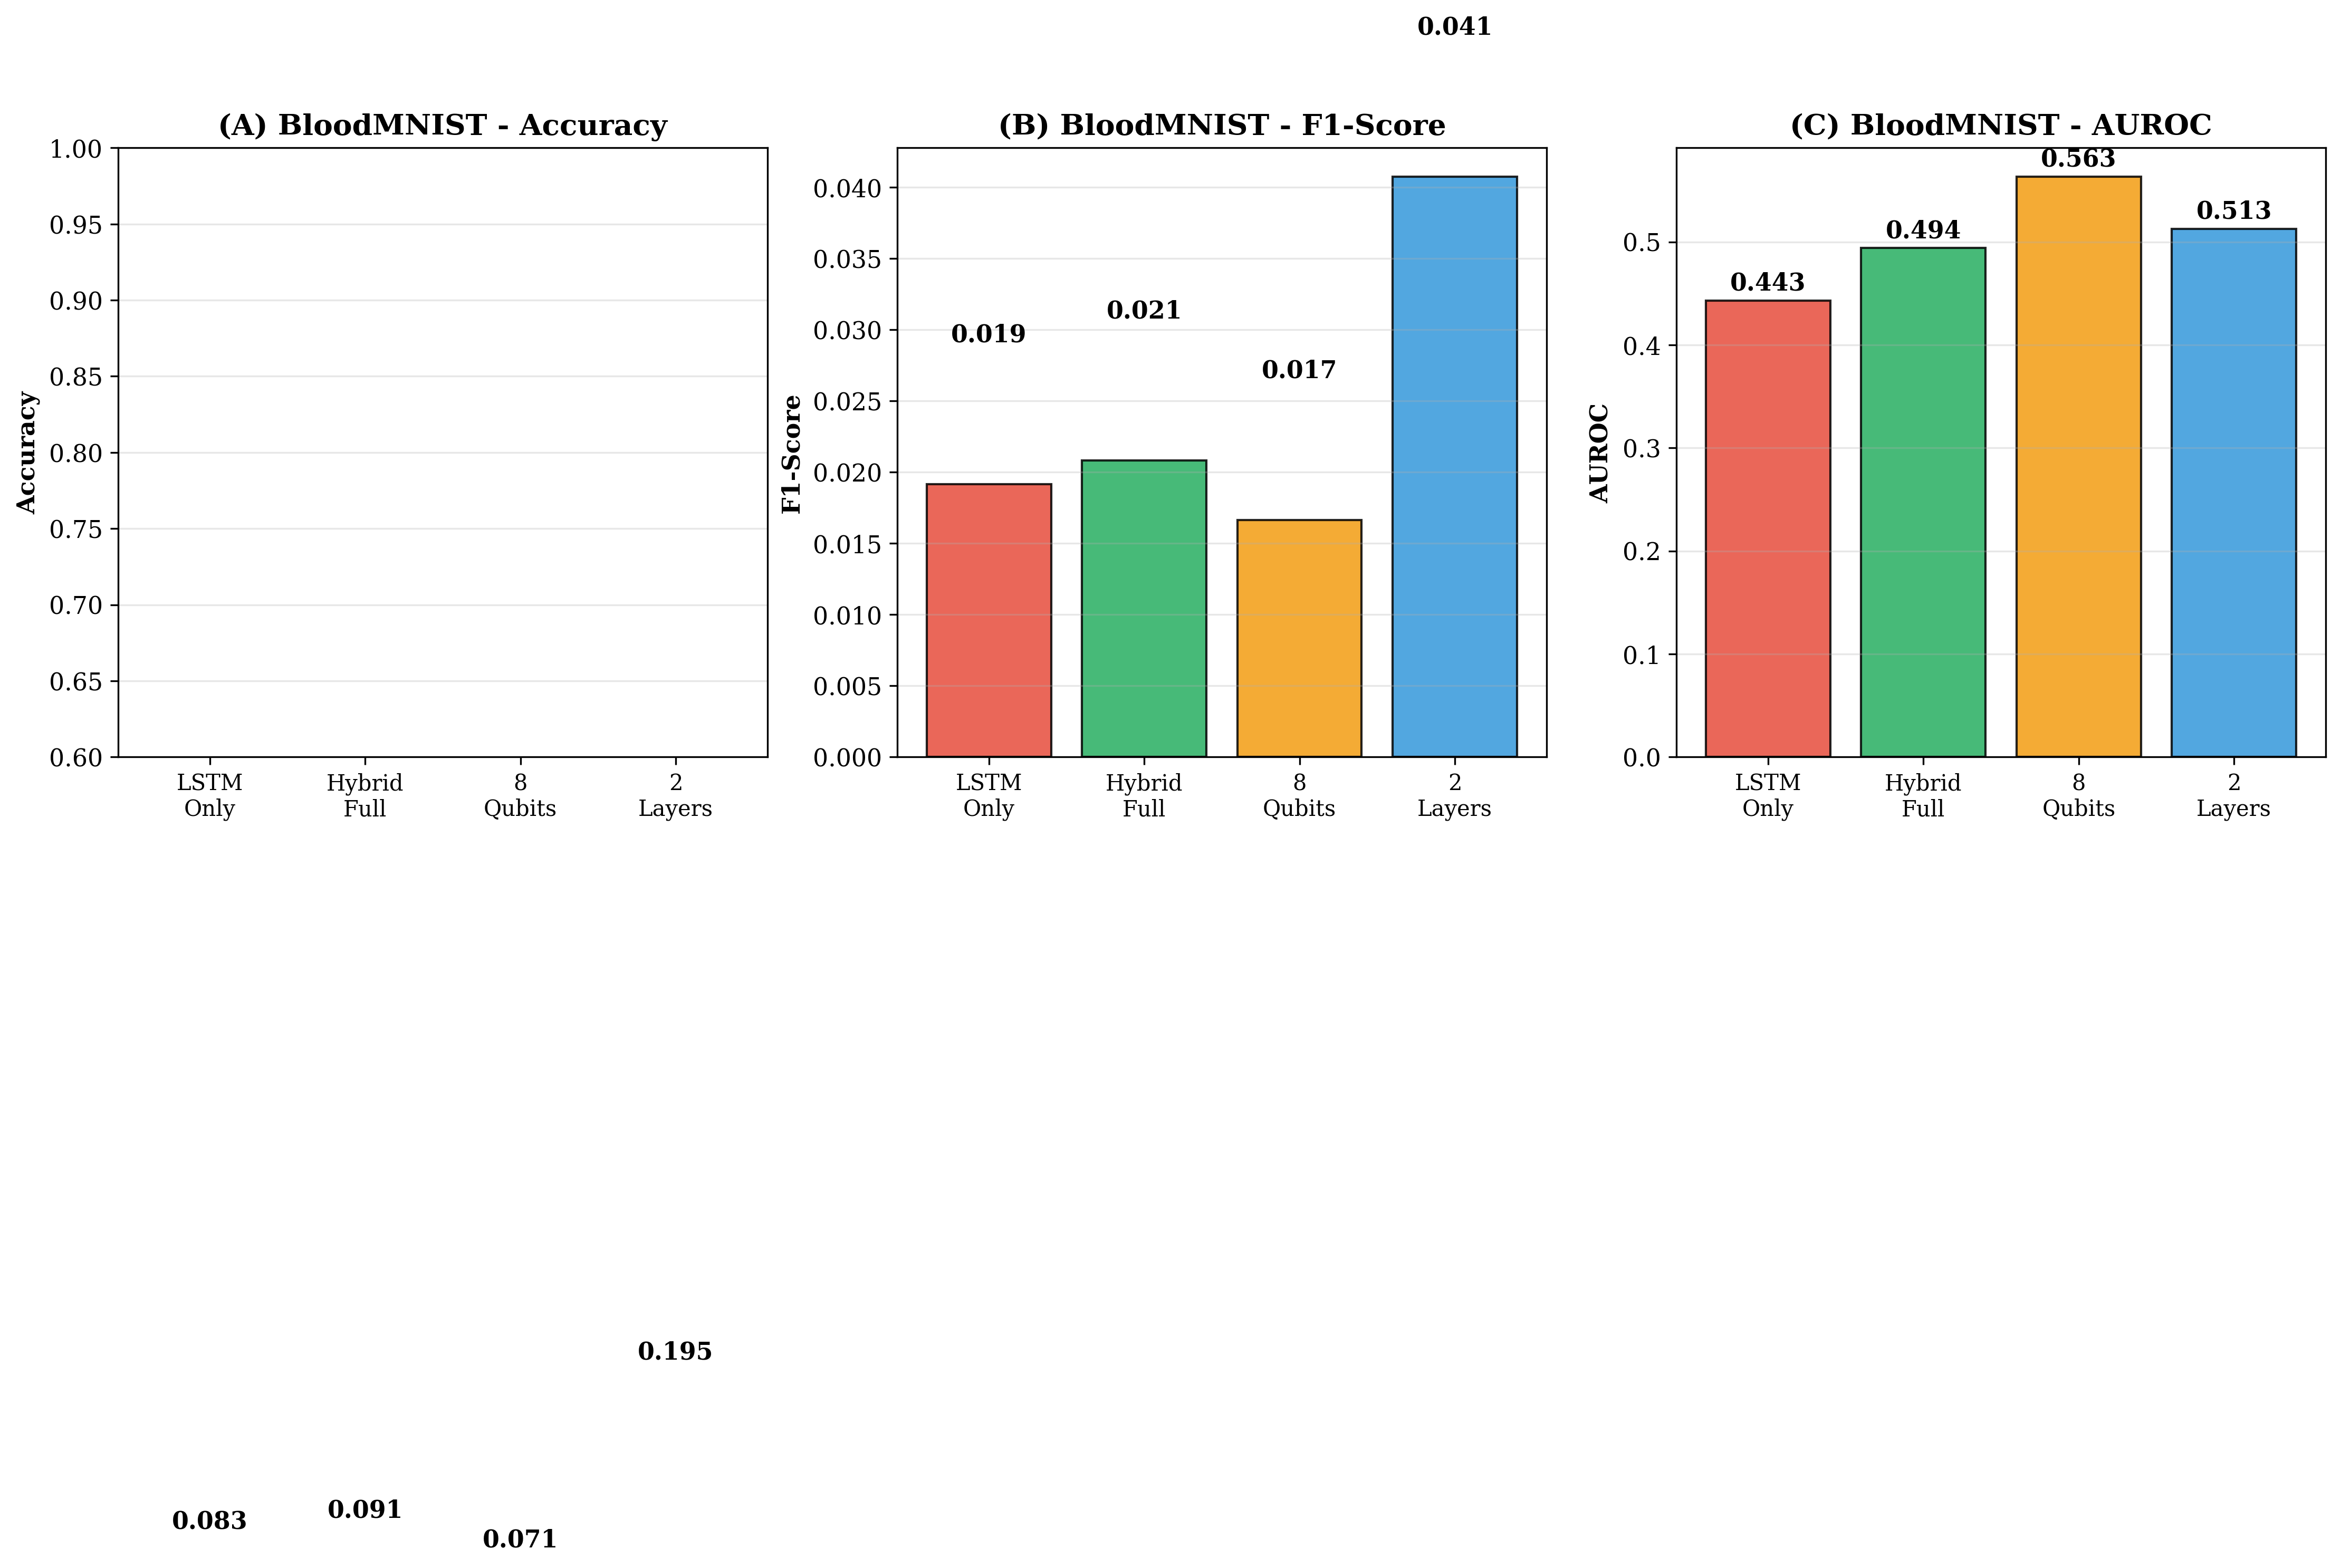

💾 Saved to: results/ablation_20251015_195100/ablation_study/BloodMNIST/BloodMNIST_ablation_comparison.png


📊 ABLATION STUDY: PneumoniaMNIST

  [1/5] Loading dataset...
  📦 Loading PneumoniaMNIST ...

  [2/5] LSTM-Only Baseline...
  ✅ LSTM-Only: Acc=0.526, F1=0.488, AUROC=0.000

  [3/5] Hybrid LSTM-QNN (Full)...
  ✅ Hybrid-Full: Acc=0.627, F1=0.393, AUROC=0.000

  [4/5] Hybrid-QNN (8 qubits)...
  ✅ Reduced-Qubits: Acc=0.625, F1=0.385, AUROC=0.000

  [5/5] Hybrid-QNN (2 layers)...
  ✅ Reduced-Layers: Acc=0.625, F1=0.385, AUROC=0.000


📊 PneumoniaMNIST Ablation Comparison


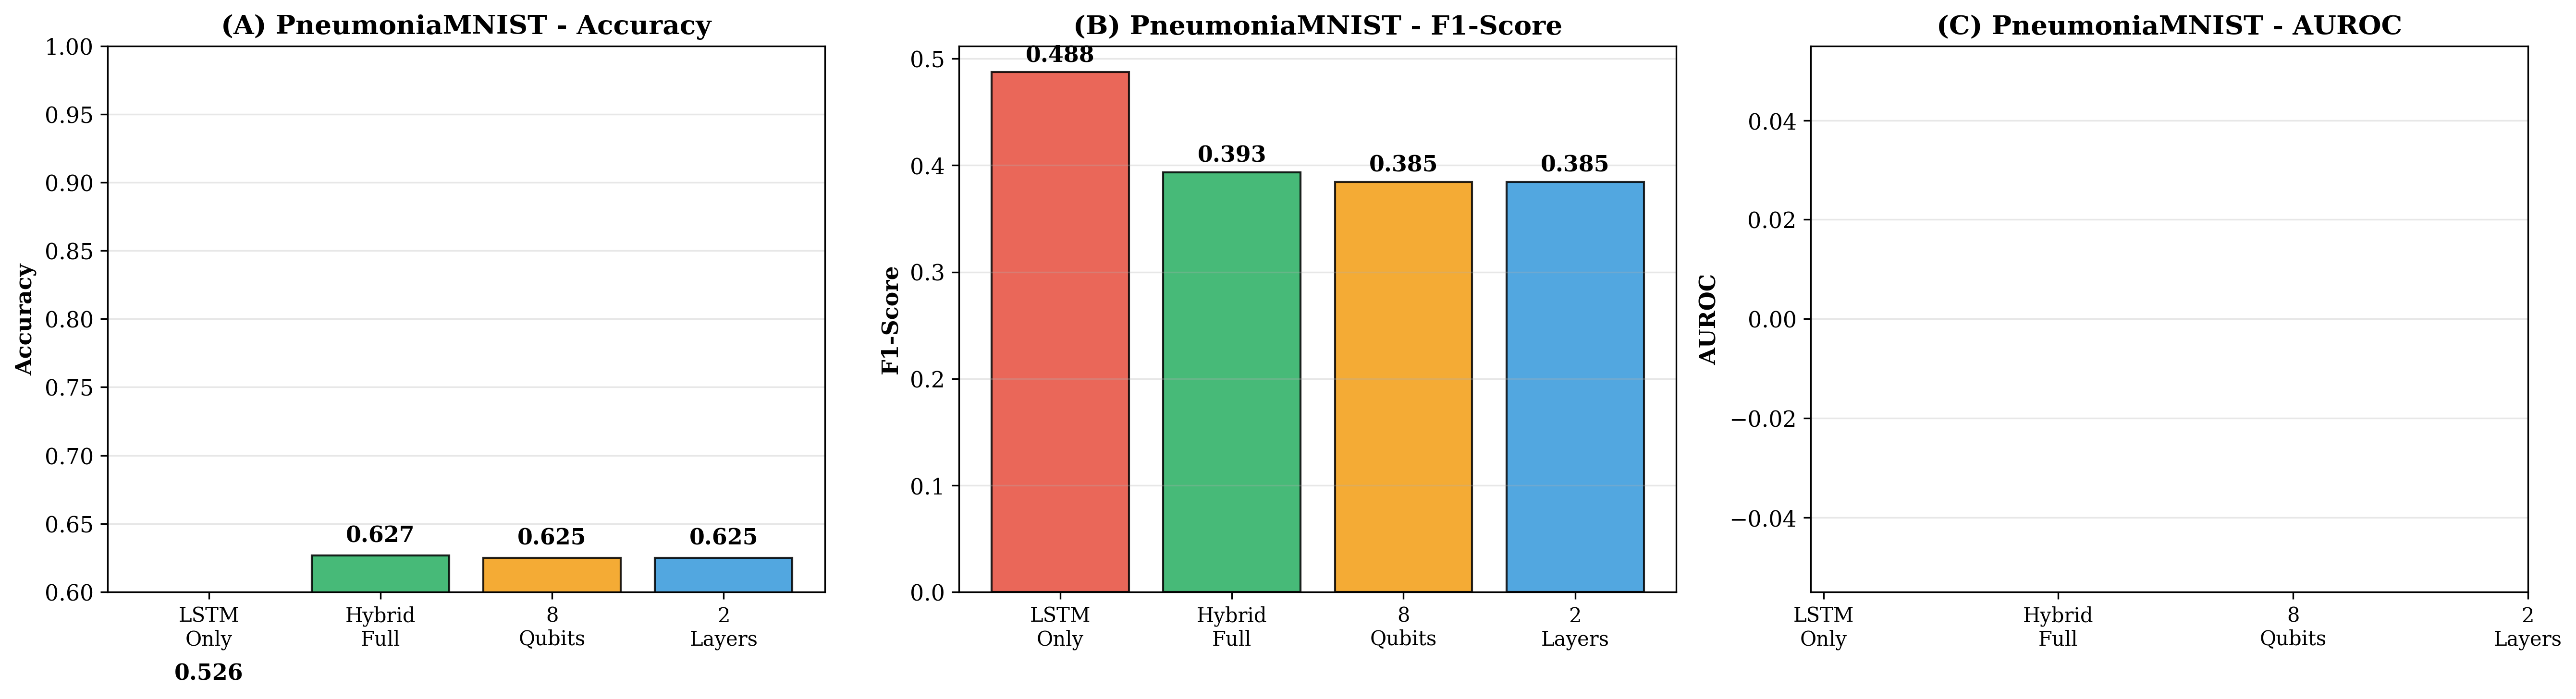

💾 Saved to: results/ablation_20251015_195100/ablation_study/PneumoniaMNIST/PneumoniaMNIST_ablation_comparison.png


📊 ABLATION STUDY: DermaMNIST

  [1/5] Loading dataset...
  📦 Loading DermaMNIST ...

  [2/5] LSTM-Only Baseline...
  ✅ LSTM-Only: Acc=0.051, F1=0.014, AUROC=0.445

  [3/5] Hybrid LSTM-QNN (Full)...
  ✅ Hybrid-Full: Acc=0.106, F1=0.028, AUROC=0.500

  [4/5] Hybrid-QNN (8 qubits)...
  ✅ Reduced-Qubits: Acc=0.110, F1=0.028, AUROC=0.509

  [5/5] Hybrid-QNN (2 layers)...
  ✅ Reduced-Layers: Acc=0.130, F1=0.039, AUROC=0.531


📊 DermaMNIST Ablation Comparison


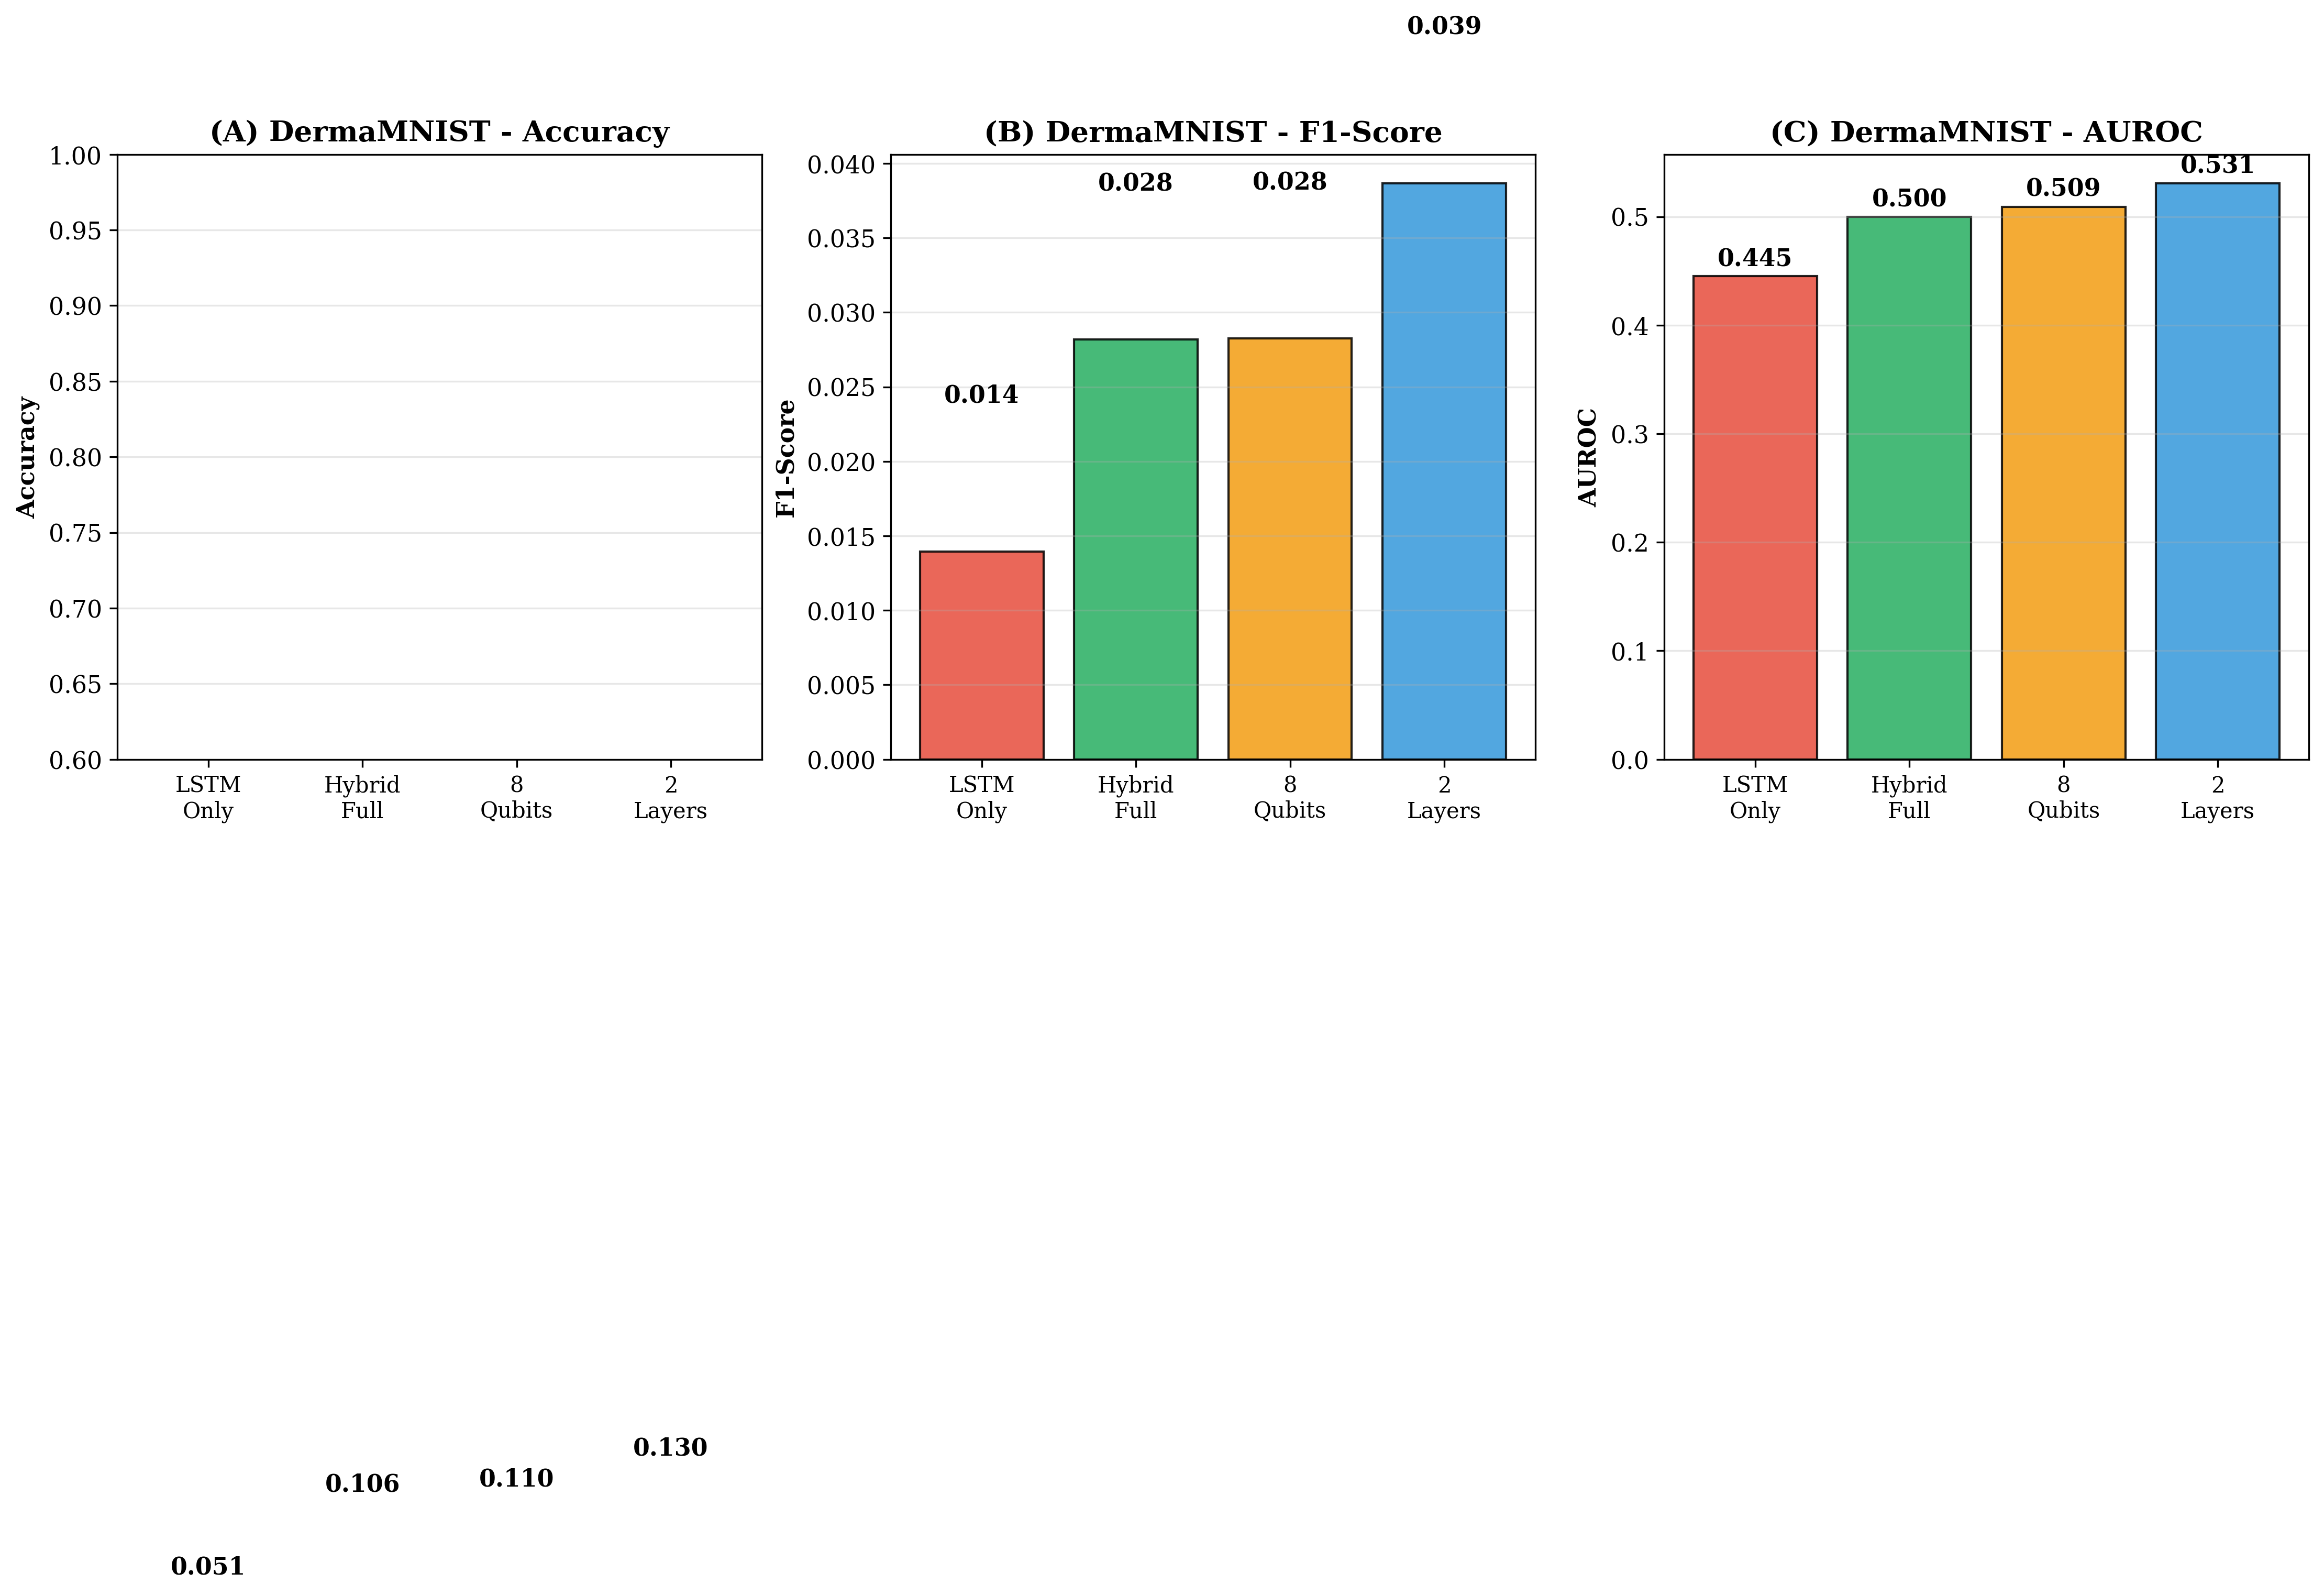

💾 Saved to: results/ablation_20251015_195100/ablation_study/DermaMNIST/DermaMNIST_ablation_comparison.png


GENERATING COMPREHENSIVE PUBLICATION FIGURES


📊 Comprehensive 6-Panel Ablation Analysis


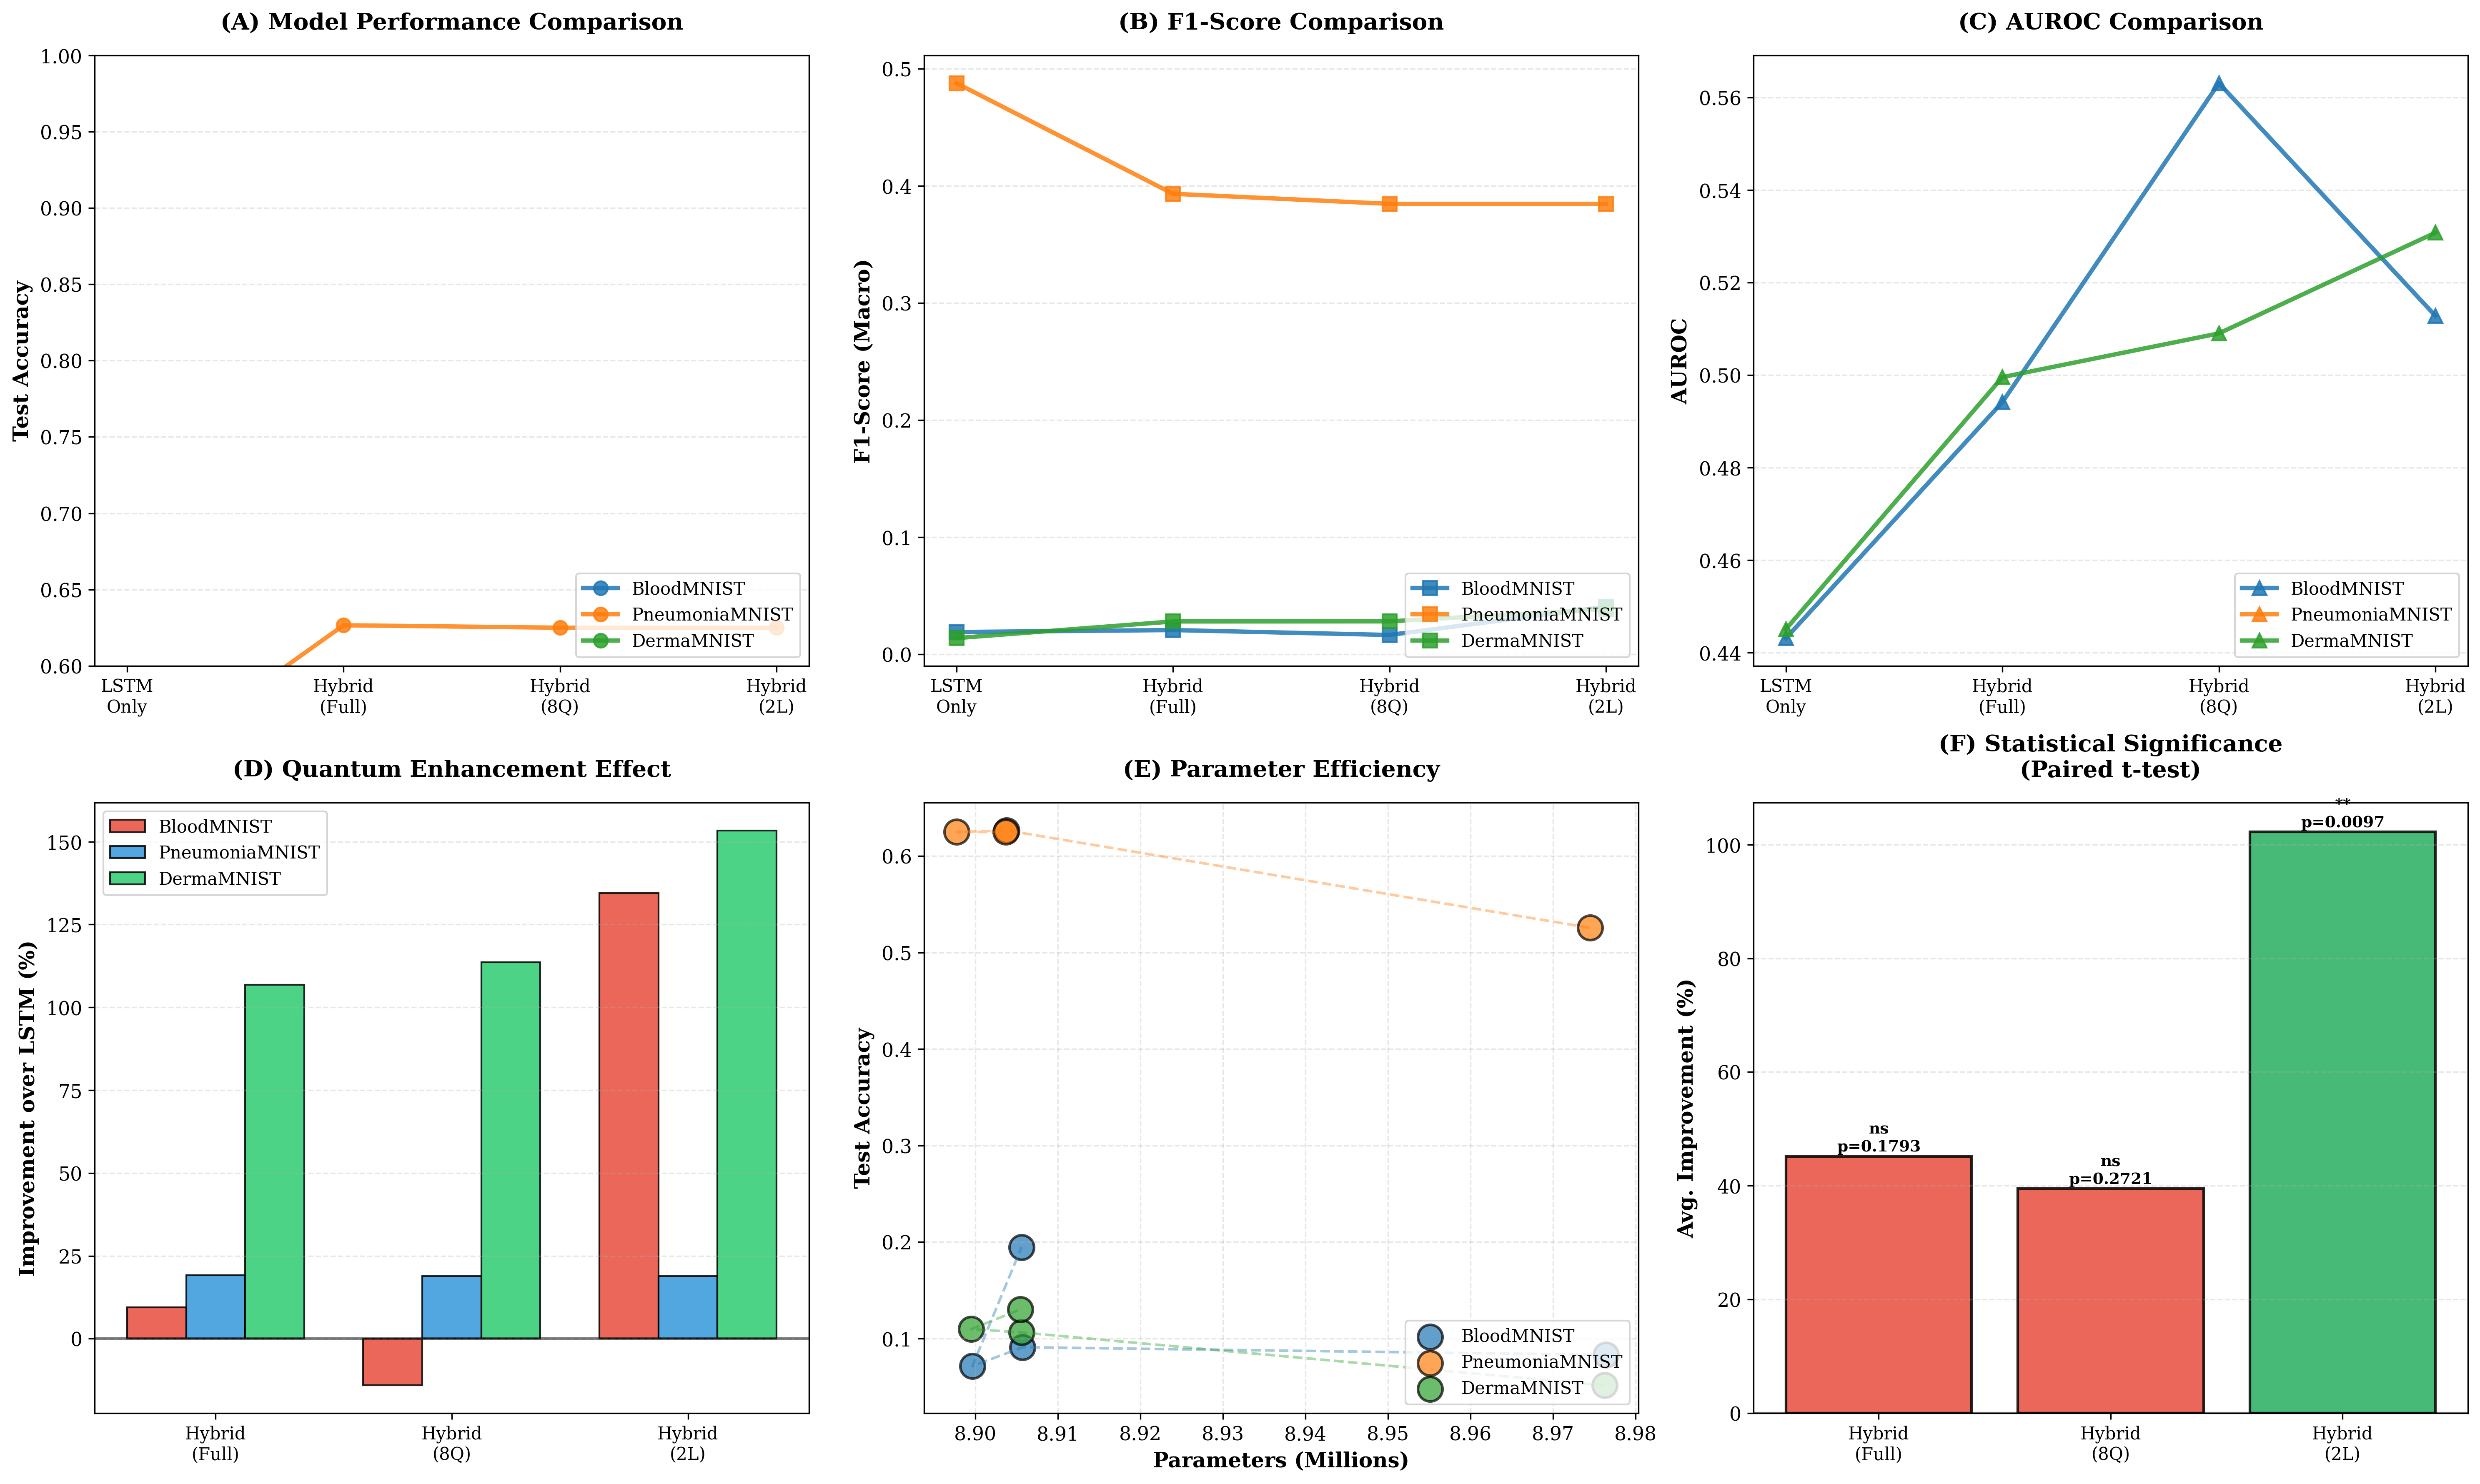

💾 Saved to: results/ablation_20251015_195100/ablation_comprehensive_analysis.png


✅ ABLATION STUDY COMPLETE!
📁 All results saved to: results/ablation_20251015_195100/

📊 FINAL RESULTS SUMMARY
--------------------------------------------------------------------------------

BloodMNIST:
  LSTM-Only (Baseline)           Acc: 0.083  F1: 0.019  AUROC: 0.443
  Hybrid LSTM-QNN (Full)         Acc: 0.091  F1: 0.021  AUROC: 0.494  (++9.5%)
  Hybrid-QNN (8 qubits)          Acc: 0.071  F1: 0.017  AUROC: 0.563  (+-14.1%)
  Hybrid-QNN (2 layers)          Acc: 0.195  F1: 0.041  AUROC: 0.513  (++134.5%)

PneumoniaMNIST:
  LSTM-Only (Baseline)           Acc: 0.526  F1: 0.488  AUROC: 0.000
  Hybrid LSTM-QNN (Full)         Acc: 0.627  F1: 0.393  AUROC: 0.000  (++19.2%)
  Hybrid-QNN (8 qubits)          Acc: 0.625  F1: 0.385  AUROC: 0.000  (++18.9%)
  Hybrid-QNN (2 layers)          Acc: 0.625  F1: 0.385  AUROC: 0.000  (++18.9%)

DermaMNIST:
  LSTM-Only (Baseline)           Acc: 0.051  F1: 0.014  AUROC: 0.

In [7]:
# =========================
# ABLATION STUDY: QNN Component Analysis (Colab-Safe, Reuse-Enabled)
# =========================
"""
Publication-ready ablation study with inline figure display.
Figures are both saved AND displayed in notebook output.
"""
import os, json, time, math, warnings
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pandas as pd
from sklearn.metrics import f1_score, roc_auc_score
from IPython.display import display, Image as IPImage, HTML
from torch.utils import data as _torch_data
from torch.utils.data import DataLoader

warnings.filterwarnings('ignore')

print("\n" + "="*80)
print("ABLATION STUDY: Quantum Neural Network Component Analysis")
print("="*80 + "\n")

# === EXECUTION MODES (self-contained flags) ===
EVAL_ONLY = True          # True: never train; load existing ckpts and only evaluate
FORCE_RETRAIN = False     # True: ignore existing files and retrain anyway
REUSE_SUMMARY = True      # True: if ablation_summary.json exists, just replot from it

# ---- Expected external utilities (Config, data, etc.) ----
try:
    to_index
except NameError:
    def to_index(labels):
        return labels.squeeze(1).long() if (labels.dim()==2 and labels.shape[1]==1) else labels.long()

# ============================================================================
# FIXED: DataLoader with num_workers=0
# ============================================================================
def make_loaders_safe(tr, va, te, batch_size=64, seed=42):
    """Safe DataLoader for Colab/Jupyter - no multiprocessing errors"""
    def seed_worker(worker_id):
        worker_seed = seed + worker_id
        np.random.seed(worker_seed)
        import random
        random.seed(worker_seed)

    g = torch.Generator().manual_seed(seed)

    tr_loader = DataLoader(tr, batch_size=batch_size, shuffle=True,
                           num_workers=0, pin_memory=True,
                           worker_init_fn=seed_worker, generator=g)
    va_loader = DataLoader(va, batch_size=batch_size, shuffle=False,
                           num_workers=0, pin_memory=True)
    te_loader = DataLoader(te, batch_size=batch_size, shuffle=False,
                           num_workers=0, pin_memory=True)

    return tr_loader, va_loader, te_loader

# ============================================================================
# MODELS (same as your originals for baseline + variants)
# ============================================================================
class QuantumCircuit(nn.Module):
    """Quantum Variational Circuit with Learnable Entanglement (simulated)."""
    def __init__(self, n_qubits, n_layers=4):
        super().__init__()
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.theta = nn.Parameter(torch.randn(n_layers, n_qubits) * 0.1)
        self.phi   = nn.Parameter(torch.randn(n_layers, n_qubits) * 0.1)
        self.omega = nn.Parameter(torch.randn(n_layers, n_qubits) * 0.1)
        self.entangle_theta = nn.Parameter(torch.randn(n_layers, n_qubits-1) * 0.1)

    def forward(self, x):  # x: [B, n_qubits] in [-1,1]
        B = x.shape[0]
        state = torch.zeros(B, 2**self.n_qubits, dtype=torch.complex64, device=x.device)
        state[:, 0] = 1.0
        for i in range(self.n_qubits):
            angle = x[:, i] * math.pi
            phase = torch.exp(1j * angle.unsqueeze(-1) / 2)
            state = state * phase
        for L in range(self.n_layers):
            for i in range(self.n_qubits):
                angle = self.theta[L, i] + self.phi[L, i] * x[:, i]
                phase = torch.exp(1j * angle.unsqueeze(-1) / 2)
                state = state * phase
            for i in range(self.n_qubits - 1):
                s = self.entangle_theta[L, i]
                ent = (1 + 0.15 * torch.sin(s)).unsqueeze(0)
                state = state * ent
        probs = torch.abs(state) ** 2
        outs = []
        for i in range(self.n_qubits):
            outs.append(probs[:, : 2**(i+1)].sum(dim=1))
        return torch.stack(outs, dim=1)

class LSTMFeatureExtractor(nn.Module):
    def __init__(self, input_channels=3, patch_size=4, hidden_dim=256, num_layers=3):
        super().__init__()
        self.patch_size = patch_size
        self.patch_embed = nn.Sequential(
            nn.Conv2d(input_channels, 64, 3, padding=1), nn.BatchNorm2d(64), nn.GELU(),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.GELU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.BatchNorm2d(128), nn.GELU(),
        )
        self.seq_len = (28 // patch_size) ** 2
        self.patch_dim = 128 * patch_size * patch_size
        self.lstm = nn.LSTM(self.patch_dim, hidden_dim, num_layers=num_layers,
                            batch_first=True, dropout=0.3 if num_layers > 1 else 0, bidirectional=True)
        self.refine = nn.Sequential(
            nn.Linear(hidden_dim*2, hidden_dim*2), nn.LayerNorm(hidden_dim*2), nn.GELU(), nn.Dropout(0.3),
            nn.Linear(hidden_dim*2, hidden_dim),   nn.LayerNorm(hidden_dim),   nn.GELU(), nn.Dropout(0.2),
        )

    def forward(self, x):
        B = x.size(0)
        x = self.patch_embed(x)
        B,C,H,W = x.shape
        ps = self.patch_size
        x = x.unfold(2, ps, ps).unfold(3, ps, ps)
        x = x.contiguous().view(B, C, -1, ps, ps)
        x = x.permute(0,2,1,3,4).contiguous().view(B, -1, self.patch_dim)
        lstm_out, _ = self.lstm(x)
        feat = self.refine(lstm_out[:, -1, :])
        return feat

class LSTMOnlyModel(nn.Module):
    """Baseline without quantum component - classical deep learning only."""
    def __init__(self, num_classes, input_channels=3, lstm_hidden=256):
        super().__init__()
        self.lstm = LSTMFeatureExtractor(input_channels, patch_size=4,
                                         hidden_dim=lstm_hidden, num_layers=3)

        self.classical_path = nn.Sequential(
            nn.Linear(lstm_hidden, 256), nn.LayerNorm(256), nn.GELU(), nn.Dropout(0.2),
            nn.Linear(256, 128),         nn.LayerNorm(128), nn.GELU(), nn.Dropout(0.1),
            nn.Linear(128, 128),         nn.LayerNorm(128), nn.GELU(), nn.Dropout(0.1),
        )

        self.fusion = nn.Sequential(
            nn.Linear(128 + lstm_hidden, 512), nn.LayerNorm(512), nn.GELU(), nn.Dropout(0.4),
            nn.Linear(512, 256),                nn.LayerNorm(256), nn.GELU(), nn.Dropout(0.3),
            nn.Linear(256, 128),                nn.LayerNorm(128), nn.GELU(), nn.Dropout(0.2),
        )
        self.cls = nn.Linear(128, num_classes)
        self.apply(self._init)

    @staticmethod
    def _init(m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None: nn.init.constant_(m.bias, 0)
        if isinstance(m, (nn.LayerNorm, nn.BatchNorm2d)):
            nn.init.constant_(m.weight, 1); nn.init.constant_(m.bias, 0)

    def forward(self, x):
        lstm_feat = self.lstm(x)
        classical_feat = self.classical_path(lstm_feat)
        fused = torch.cat([classical_feat, lstm_feat], dim=1)
        z = self.fusion(fused)
        return self.cls(z)

class HybridLSTMQNN_Variant(nn.Module):
    """Quantum-enhanced model with configurable QNN architecture."""
    def __init__(self, num_classes, input_channels=3, lstm_hidden=256,
                 n_qubits=16, qnn_layers=4):
        super().__init__()
        self.n_qubits = n_qubits
        self.qnn_layers = qnn_layers

        self.lstm = LSTMFeatureExtractor(input_channels, patch_size=4,
                                         hidden_dim=lstm_hidden, num_layers=3)

        self.to_q = nn.Sequential(
            nn.Linear(lstm_hidden, 256), nn.LayerNorm(256), nn.GELU(), nn.Dropout(0.2),
            nn.Linear(256, 128),         nn.LayerNorm(128), nn.GELU(), nn.Dropout(0.1),
            nn.Linear(128, n_qubits), nn.Tanh()
        )

        self.qnn = QuantumCircuit(n_qubits, n_layers=qnn_layers)

        self.q_gate = nn.Sequential(
            nn.Linear(n_qubits, n_qubits*2), nn.LayerNorm(n_qubits*2), nn.GELU(),
            nn.Linear(n_qubits*2, n_qubits), nn.Sigmoid()
        )

        self.fusion = nn.Sequential(
            nn.Linear(n_qubits + lstm_hidden, 512), nn.LayerNorm(512), nn.GELU(), nn.Dropout(0.4),
            nn.Linear(512, 256),                    nn.LayerNorm(256), nn.GELU(), nn.Dropout(0.3),
            nn.Linear(256, 128),                    nn.LayerNorm(128), nn.GELU(), nn.Dropout(0.2),
        )
        self.cls = nn.Linear(128, num_classes)
        self.apply(self._init)

    @staticmethod
    def _init(m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None: nn.init.constant_(m.bias, 0)
        if isinstance(m, (nn.LayerNorm, nn.BatchNorm2d)):
            nn.init.constant_(m.weight, 1); nn.init.constant_(m.bias, 0)

    def forward(self, x):
        lstm_feat = self.lstm(x)
        q_in = self.to_q(lstm_feat)
        q_out = self.qnn(q_in)
        gate = self.q_gate(q_in)
        q_enh = q_out * gate + q_in * (1 - gate)
        fused = torch.cat([q_enh, lstm_feat], dim=1)
        z = self.fusion(fused)
        return self.cls(z)

# ============================================================================
# HELPER FUNCTIONS (unchanged)
# ============================================================================
def focal_loss(logits, targets, alpha=0.25, gamma=2.0):
    ce = F.cross_entropy(logits, targets, reduction='none')
    pt = torch.exp(-ce)
    return (alpha * (1-pt)**gamma * ce).mean()

def label_smoothing_loss(logits, targets, smoothing=0.1):
    n = logits.size(-1)
    true = torch.full_like(logits, smoothing/(n-1))
    true.scatter_(1, targets.unsqueeze(1), 1.0 - smoothing)
    return torch.mean(torch.sum(-true * F.log_softmax(logits, dim=-1), dim=-1))

def mixup_data(x, y, alpha=0.2):
    lam = np.random.beta(alpha, alpha) if alpha > 0 else 1.0
    idx = torch.randperm(x.size(0), device=x.device)
    return lam * x + (1-lam) * x[idx], y, y[idx], lam

def mixup_criterion(crit, pred, y_a, y_b, lam):
    return lam * crit(pred, y_a) + (1-lam) * crit(pred, y_b)

def display_image_inline(image_path, title=""):
    print(f"\n{'='*70}")
    if title:
        print(f"📊 {title}")
        print(f"{'='*70}")
    display(IPImage(filename=str(image_path)))
    print(f"💾 Saved to: {image_path}")
    print(f"{'='*70}\n")

# ============================================================================
# TRAINING WRAPPER (load-or-train guard added; training loop unchanged)
# ============================================================================
def train_ablation_model(model, num_classes, n_channels, loaders, epochs,
                         save_prefix, class_weights=None, model_name="Model",
                         force_retrain: bool = False, eval_only: bool = False):
    """Train ablation variant with detailed progress bars.
       If checkpoint exists (or eval_only), just load & return (no training)."""
    tr_loader, va_loader, _ = loaders
    model = model.to(Config.DEVICE)
    ckpt_path = f"{save_prefix}_best.pt"

    # Fast path
    if not force_retrain and (eval_only or os.path.exists(ckpt_path)):
        if os.path.exists(ckpt_path):
            model.load_state_dict(torch.load(ckpt_path, map_location=Config.DEVICE))
        return model, None, [], []

    # Original training logic
    weights = torch.tensor(class_weights, dtype=torch.float32, device=Config.DEVICE) if class_weights else None
    ce = nn.CrossEntropyLoss(weight=weights) if weights is not None else nn.CrossEntropyLoss()

    optim = torch.optim.AdamW(model.parameters(), lr=Config.LEARNING_RATE,
                              weight_decay=Config.WEIGHT_DECAY)
    sched = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optim, T_0=15, T_mult=2, eta_min=1e-6)

    best_val, patience = 0.0, 0
    train_losses, val_accs = [], []

    pbar_epoch = tqdm(range(1, epochs+1), unit="epoch", desc=f"Training {model_name}", position=0)

    for ep in pbar_epoch:
        model.train()
        tot_loss = 0.0
        batch_count = 0

        pbar_train = tqdm(tr_loader, desc=f"  Epoch {ep:02d} - Train",
                          leave=False, position=1, colour='blue')

        for x, y in pbar_train:
            x, y = x.to(Config.DEVICE), to_index(y).to(Config.DEVICE)

            if np.random.rand() < 0.5:
                mx, ya, yb, lam = mixup_data(x, y, alpha=0.2)
                logits = model(mx)
                loss = mixup_criterion(ce, logits, ya, yb, lam)
            else:
                logits = model(x)
                r = np.random.rand()
                if r < 0.3:
                    loss = focal_loss(logits, y)
                elif r < 0.8:
                    loss = label_smoothing_loss(logits, y, 0.1)
                else:
                    loss = ce(logits, y)

            optim.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optim.step()

            tot_loss += loss.item()
            batch_count += 1
            pbar_train.set_postfix(loss=f"{loss.item():.4f}", avg_loss=f"{tot_loss/batch_count:.4f}")

        pbar_train.close()
        sched.step()
        train_losses.append(tot_loss / batch_count)

        # Validation
        model.eval()
        correct, total = 0, 0

        pbar_val = tqdm(va_loader, desc=f"  Epoch {ep:02d} - Val",
                        leave=False, position=1, colour='green')

        with torch.no_grad():
            for x, y in pbar_val:
                x, y = x.to(Config.DEVICE), to_index(y).to(Config.DEVICE)
                pred = model(x).argmax(1)
                correct += (pred == y).sum().item()
                total += y.size(0)
                pbar_val.set_postfix(acc=f"{correct/total:.3f}")

        pbar_val.close()

        val_acc = correct / total
        val_accs.append(val_acc)

        pbar_epoch.set_postfix(
            val_acc=f"{val_acc:.3f}",
            best=f"{best_val:.3f}",
            loss=f"{train_losses[-1]:.4f}",
            patience=f"{patience}/{Config.PATIENCE}"
        )

        if val_acc > best_val:
            best_val = val_acc
            patience = 0
            torch.save(model.state_dict(), ckpt_path)
        else:
            patience += 1

        if patience >= Config.PATIENCE:
            pbar_epoch.write(f"  ⏹️  Early stopping at epoch {ep}")
            break

    pbar_epoch.close()
    model.load_state_dict(torch.load(ckpt_path, map_location=Config.DEVICE))

    return model, best_val, train_losses, val_accs

# ============================================================================
# EVALUATION (unchanged)
# ============================================================================
def evaluate_model(model, loaders, num_classes, use_tta=False):
    _, _, te_loader = loaders
    model.eval(); logits_all=[]; labels_all=[]
    with torch.no_grad():
        for x,y in te_loader:
            x,y = x.to(Config.DEVICE), to_index(y).to(Config.DEVICE)
            if use_tta:
                outs = [model(x), model(torch.flip(x,[3])), model(torch.flip(x,[2]))]
                logits = torch.stack(outs).mean(0)
            else:
                logits = model(x)
            logits_all.append(logits.cpu()); labels_all.append(y.cpu())
    logits = torch.cat(logits_all); labels = torch.cat(labels_all)
    probs = torch.softmax(logits, dim=1); preds = logits.argmax(1)
    acc = (preds==labels).float().mean().item()
    f1  = f1_score(labels.numpy(), preds.numpy(), average='macro')
    try:
        auroc = roc_auc_score(labels.numpy(),
                              probs[:,1].numpy() if num_classes==2 else probs.numpy(),
                              multi_class=None if num_classes==2 else 'ovr',
                              average='macro' if num_classes>2 else None)
    except Exception:
        auroc = 0.0
    return {'acc':acc, 'f1':f1, 'auroc':auroc, 'logits':logits, 'y':labels}

# ============================================================================
# FIGURE GENERATION WITH INLINE DISPLAY (unchanged)
# ============================================================================
def plot_dataset_comparison(dataset_name, results, output_dir: Path):
    plt.rcParams.update({'font.family': 'serif', 'font.size': 11, 'figure.dpi': 150})
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    models = [r['model'] for r in results]
    accs = [r['acc'] for r in results]
    f1s = [r['f1'] for r in results]
    aurocs = [r['auroc'] if r['auroc'] > 0 else np.nan for r in results]

    colors = ['#e74c3c', '#27ae60', '#f39c12', '#3498db']

    axes[0].bar(range(len(models)), accs, color=colors, alpha=0.85, edgecolor='black')
    axes[0].set_xticks(range(len(models)))
    axes[0].set_xticklabels(['LSTM\nOnly', 'Hybrid\nFull', '8\nQubits', '2\nLayers'], fontsize=10)
    axes[0].set_ylabel('Accuracy', fontweight='bold')
    axes[0].set_title(f'(A) {dataset_name} - Accuracy', fontweight='bold')
    axes[0].grid(axis='y', alpha=0.3)
    axes[0].set_ylim([0.6, 1.0])
    for i, v in enumerate(accs):
        axes[0].text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

    axes[1].bar(range(len(models)), f1s, color=colors, alpha=0.85, edgecolor='black')
    axes[1].set_xticks(range(len(models)))
    axes[1].set_xticklabels(['LSTM\nOnly', 'Hybrid\nFull', '8\nQubits', '2\nLayers'], fontsize=10)
    axes[1].set_ylabel('F1-Score', fontweight='bold')
    axes[1].set_title(f'(B) {dataset_name} - F1-Score', fontweight='bold')
    axes[1].grid(axis='y', alpha=0.3)
    for i, v in enumerate(f1s):
        axes[1].text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

    axes[2].bar(range(len(models)), aurocs, color=colors, alpha=0.85, edgecolor='black')
    axes[2].set_xticks(range(len(models)))
    axes[2].set_xticklabels(['LSTM\nOnly', 'Hybrid\nFull', '8\nQubits', '2\nLayers'], fontsize=10)
    axes[2].set_ylabel('AUROC', fontweight='bold')
    axes[2].set_title(f'(C) {dataset_name} - AUROC', fontweight='bold')
    axes[2].grid(axis='y', alpha=0.3)
    for i, v in enumerate(aurocs):
        if not np.isnan(v):
            axes[2].text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

    plt.tight_layout()
    output_path = output_dir / f"{dataset_name}_ablation_comparison.png"
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    display_image_inline(output_path, f"{dataset_name} Ablation Comparison")
    plt.close()

def plot_ablation_comprehensive(all_results, output_dir: Path):
    print("\n" + "="*70)
    print("GENERATING COMPREHENSIVE PUBLICATION FIGURES")
    print("="*70 + "\n")

    plt.rcParams.update({'font.family': 'serif', 'font.size': 11, 'figure.dpi': 150})
    datasets = list(all_results.keys())
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))

    ax1 = axes[0, 0]
    for dataset in datasets:
        results = all_results[dataset]
        accs = [r['acc'] for r in results]
        x_pos = np.arange(len(results))
        ax1.plot(x_pos, accs, marker='o', linewidth=2.5, markersize=8, label=dataset, alpha=0.85)
    ax1.set_xticks(range(4))
    ax1.set_xticklabels(['LSTM\nOnly', 'Hybrid\n(Full)', 'Hybrid\n(8Q)', 'Hybrid\n(2L)'], fontsize=10)
    ax1.set_ylabel('Test Accuracy', fontweight='bold', fontsize=12)
    ax1.set_title('(A) Model Performance Comparison', fontweight='bold', pad=15)
    ax1.legend(loc='lower right', fontsize=10)
    ax1.grid(axis='y', alpha=0.3, linestyle='--')
    ax1.set_ylim([0.6, 1.0])

    ax2 = axes[0, 1]
    for dataset in datasets:
        results = all_results[dataset]
        f1s = [r['f1'] for r in results]
        x_pos = np.arange(len(results))
        ax2.plot(x_pos, f1s, marker='s', linewidth=2.5, markersize=8, label=dataset, alpha=0.85)
    ax2.set_xticks(range(4))
    ax2.set_xticklabels(['LSTM\nOnly', 'Hybrid\n(Full)', 'Hybrid\n(8Q)', 'Hybrid\n(2L)'], fontsize=10)
    ax2.set_ylabel('F1-Score (Macro)', fontweight='bold', fontsize=12)
    ax2.set_title('(B) F1-Score Comparison', fontweight='bold', pad=15)
    ax2.legend(loc='lower right', fontsize=10)
    ax2.grid(axis='y', alpha=0.3, linestyle='--')

    ax3 = axes[0, 2]
    for dataset in datasets:
        results = all_results[dataset]
        aurocs = [r['auroc'] if r['auroc'] > 0 else np.nan for r in results]
        x_pos = np.arange(len(results))
        ax3.plot(x_pos, aurocs, marker='^', linewidth=2.5, markersize=8, label=dataset, alpha=0.85)
    ax3.set_xticks(range(4))
    ax3.set_xticklabels(['LSTM\nOnly', 'Hybrid\n(Full)', 'Hybrid\n(8Q)', 'Hybrid\n(2L)'], fontsize=10)
    ax3.set_ylabel('AUROC', fontweight='bold', fontsize=12)
    ax3.set_title('(C) AUROC Comparison', fontweight='bold', pad=15)
    ax3.legend(loc='lower right', fontsize=10)
    ax3.grid(axis='y', alpha=0.3, linestyle='--')

    ax4 = axes[1, 0]
    improvements = {ds: [] for ds in datasets}
    for dataset in datasets:
        results = all_results[dataset]
        baseline_acc = results[0]['acc']
        for r in results[1:]:
            improvement = ((r['acc'] - baseline_acc) / baseline_acc) * 100
            improvements[dataset].append(improvement)
    x_pos = np.arange(3); width = 0.25
    colors = ['#e74c3c', '#3498db', '#2ecc71']
    for i, dataset in enumerate(datasets):
        ax4.bar(x_pos + i*width, improvements[dataset], width,
                label=dataset, color=colors[i], alpha=0.85, edgecolor='black')
    ax4.set_xticks(x_pos + width)
    ax4.set_xticklabels(['Hybrid\n(Full)', 'Hybrid\n(8Q)', 'Hybrid\n(2L)'], fontsize=10)
    ax4.set_ylabel('Improvement over LSTM (%)', fontweight='bold', fontsize=12)
    ax4.set_title('(D) Quantum Enhancement Effect', fontweight='bold', pad=15)
    ax4.legend(loc='upper left', fontsize=10)
    ax4.grid(axis='y', alpha=0.3, linestyle='--')
    ax4.axhline(y=0, color='black', linestyle='-', linewidth=1.5, alpha=0.5)

    ax5 = axes[1, 1]
    for dataset in datasets:
        results = all_results[dataset]
        params = [r['n_params'] / 1e6 for r in results]
        accs = [r['acc'] for r in results]
        ax5.scatter(params, accs, s=200, alpha=0.7, label=dataset, edgecolors='black', linewidth=1.5)
        ax5.plot(params, accs, alpha=0.4, linewidth=1.5, linestyle='--')
    ax5.set_xlabel('Parameters (Millions)', fontweight='bold', fontsize=12)
    ax5.set_ylabel('Test Accuracy', fontweight='bold', fontsize=12)
    ax5.set_title('(E) Parameter Efficiency', fontweight='bold', pad=15)
    ax5.legend(loc='lower right', fontsize=10)
    ax5.grid(alpha=0.3, linestyle='--')

    ax6 = axes[1, 2]
    avg_improvements, p_values = [], []
    for model_idx in range(1, 4):
        baseline_accs = [all_results[ds][0]['acc'] for ds in datasets]
        variant_accs = [all_results[ds][model_idx]['acc'] for ds in datasets]
        avg_imp = np.mean([(v - b) / b * 100 for v, b in zip(variant_accs, baseline_accs)])
        avg_improvements.append(avg_imp)
        t_stat, p_val = stats.ttest_rel(variant_accs, baseline_accs)
        p_values.append(p_val)
    colors_sig = ['#27ae60' if p < 0.05 else '#e74c3c' if p > 0.1 else '#f39c12' for p in p_values]
    bars = ax6.bar(range(3), avg_improvements, color=colors_sig, alpha=0.85, edgecolor='black', linewidth=1.5)
    ax6.set_xticks(range(3))
    ax6.set_xticklabels(['Hybrid\n(Full)', 'Hybrid\n(8Q)', 'Hybrid\n(2L)'], fontsize=10)
    ax6.set_ylabel('Avg. Improvement (%)', fontweight='bold', fontsize=12)
    ax6.set_title('(F) Statistical Significance\n(Paired t-test)', fontweight='bold', pad=15)
    ax6.grid(axis='y', alpha=0.3, linestyle='--')
    ax6.axhline(y=0, color='black', linestyle='-', linewidth=1.5, alpha=0.5)
    for i, (bar, p_val) in enumerate(zip(bars, p_values)):
        height = bar.get_height()
        sig = '***' if p_val < 0.001 else '**' if p_val < 0.01 else '*' if p_val < 0.05 else 'ns'
        ax6.text(bar.get_x() + bar.get_width()/2., height + 0.3,
                 f'{sig}\np={p_val:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

    plt.tight_layout()
    output_path = output_dir / "ablation_comprehensive_analysis.png"
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    display_image_inline(output_path, "Comprehensive 6-Panel Ablation Analysis")
    plt.close()

def create_summary_table_with_display(all_results, output_dir: Path):
    table_data = []
    for dataset in all_results.keys():
        for result in all_results[dataset]:
            table_data.append({
                'Dataset': dataset,
                'Model': result['model'],
                'Accuracy': f"{result['acc']:.3f}",
                'Acc (TTA)': f"{result['acc_tta']:.3f}",
                'F1-Score': f"{result['f1']:.3f}",
                'AUROC': f"{result['auroc']:.3f}" if result['auroc'] > 0 else 'N/A',
                'Params (M)': f"{result['n_params']/1e6:.2f}"
            })
    df = pd.DataFrame(table_data)
    fig, ax = plt.subplots(figsize=(18, len(df)*0.4 + 2))
    ax.axis('tight'); ax.axis('off')
    cell_colors = []
    for i in range(len(df)):
        if 'LSTM-Only' in df.iloc[i]['Model']:
            cell_colors.append(['#ffebee'] * len(df.columns))
        elif 'Full' in df.iloc[i]['Model']:
            cell_colors.append(['#e8f5e9'] * len(df.columns))
        else:
            cell_colors.append(['#fff9e1'] * len(df.columns))
    table = ax.table(cellText=df.values, colLabels=df.columns,
                     cellLoc='center', loc='center',
                     cellColours=cell_colors, bbox=[0,0,1,1])
    table.auto_set_font_size(False); table.set_fontsize(10); table.scale(1, 2.5)
    for i in range(len(df.columns)):
        table[(0, i)].set_facecolor('#1565c0')
        table[(0, i)].set_text_props(weight='bold', color='white')
    for i in range(1, len(df) + 1):
        table[(i, 1)].set_text_props(weight='bold')
    plt.title('Ablation Study: Complete Results Summary\nQuantum Neural Network Component Analysis',
              fontsize=14, fontweight='bold', pad=20)
    output_path = output_dir / "ablation_summary_table.png"
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    display_image_inline(output_path, "Summary Table - All Results")
    plt.close()
    csv_path = output_path.with_suffix('.csv')
    df.to_csv(csv_path, index=False)
    print(f"✅ CSV exported to: {csv_path}")

# ============================================================================
# ABLATION STUDY EXECUTION (reuse-aware)
# ============================================================================
def run_ablation_study_for_dataset(dataset_name, results_root: Path):
    print(f"\n{'='*70}")
    print(f"📊 ABLATION STUDY: {dataset_name}")
    print(f"{'='*70}\n")

    print("  [1/5] Loading dataset...")
    tr, va, te, K, nC, info, dist = get_datasets(dataset_name, Config.CACHE_DIR)
    loaders = make_loaders_safe(tr, va, te, Config.BATCH_SIZE, Config.AUG_SEED)
    cweights = class_weights_from_counts(dist["train"])

    ablation_dir = results_root / "ablation_study" / dataset_name
    ablation_dir.mkdir(parents=True, exist_ok=True)
    summary_path = ablation_dir / "ablation_summary.json"

    # Summary-only fast path
    if REUSE_SUMMARY and summary_path.exists() and not FORCE_RETRAIN:
        with open(summary_path, "r") as f:
            saved = json.load(f)
        plot_dataset_comparison(dataset_name, saved, ablation_dir)
        return saved, ablation_dir

    ablation_results = []

    def _run_variant(model_ctor, tag, pretty_name):
        model = model_ctor()
        m, v, losses, vals = train_ablation_model(
            model, K, nC, loaders, Config.EPOCHS_CORE,
            str(ablation_dir / tag), cweights, pretty_name,
            force_retrain=FORCE_RETRAIN, eval_only=EVAL_ONLY
        )
        res = evaluate_model(m, loaders, K, use_tta=False)
        res_tta = evaluate_model(m, loaders, K, use_tta=True)
        return m, v, losses, vals, res, res_tta

    # Model 1: LSTM-Only
    print("\n  [2/5] LSTM-Only Baseline...")
    lstm_ctor = lambda: LSTMOnlyModel(K, input_channels=nC)
    lstm_model, lstm_val, lstm_losses, lstm_val_accs, lstm_results, lstm_tta = \
        _run_variant(lstm_ctor, "lstm_only", "LSTM-Only (Baseline)")
    ablation_results.append({
        'model': 'LSTM-Only (Baseline)',
        'acc': lstm_results['acc'], 'acc_tta': lstm_tta['acc'],
        'f1': lstm_results['f1'], 'auroc': lstm_results['auroc'],
        'n_params': sum(p.numel() for p in lstm_model.parameters()),
        'val_acc_history': lstm_val_accs, 'loss_history': lstm_losses
    })
    print(f"  ✅ LSTM-Only: Acc={lstm_results['acc']:.3f}, F1={lstm_results['f1']:.3f}, AUROC={lstm_results['auroc']:.3f}\n")

    # Model 2: Hybrid Full
    print("  [3/5] Hybrid LSTM-QNN (Full)...")
    full_ctor = lambda: HybridLSTMQNN_Variant(K, input_channels=nC, n_qubits=16, qnn_layers=4)
    hybrid_model, hybrid_val, hybrid_losses, hybrid_val_accs, hybrid_results, hybrid_tta = \
        _run_variant(full_ctor, "hybrid_full", "Hybrid-QNN-Full")
    ablation_results.append({
        'model': 'Hybrid LSTM-QNN (Full)',
        'acc': hybrid_results['acc'], 'acc_tta': hybrid_tta['acc'],
        'f1': hybrid_results['f1'], 'auroc': hybrid_results['auroc'],
        'n_params': sum(p.numel() for p in hybrid_model.parameters()),
        'val_acc_history': hybrid_val_accs, 'loss_history': hybrid_losses
    })
    print(f"  ✅ Hybrid-Full: Acc={hybrid_results['acc']:.3f}, F1={hybrid_results['f1']:.3f}, AUROC={hybrid_results['auroc']:.3f}\n")

    # Model 3: Reduced Qubits
    print("  [4/5] Hybrid-QNN (8 qubits)...")
    q8_ctor = lambda: HybridLSTMQNN_Variant(K, input_channels=nC, n_qubits=8, qnn_layers=4)
    reduced_q_model, _, reduced_q_losses, reduced_q_val_accs, reduced_q_results, reduced_q_tta = \
        _run_variant(q8_ctor, "hybrid_reduced_qubits", "Hybrid-QNN-8Q")
    ablation_results.append({
        'model': 'Hybrid-QNN (8 qubits)',
        'acc': reduced_q_results['acc'], 'acc_tta': reduced_q_tta['acc'],
        'f1': reduced_q_results['f1'], 'auroc': reduced_q_results['auroc'],
        'n_params': sum(p.numel() for p in reduced_q_model.parameters()),
        'val_acc_history': reduced_q_val_accs, 'loss_history': reduced_q_losses
    })
    print(f"  ✅ Reduced-Qubits: Acc={reduced_q_results['acc']:.3f}, F1={reduced_q_results['f1']:.3f}, AUROC={reduced_q_results['auroc']:.3f}\n")

    # Model 4: Reduced Layers
    print("  [5/5] Hybrid-QNN (2 layers)...")
    l2_ctor = lambda: HybridLSTMQNN_Variant(K, input_channels=nC, n_qubits=16, qnn_layers=2)
    reduced_l_model, _, reduced_l_losses, reduced_l_val_accs, reduced_l_results, reduced_l_tta = \
        _run_variant(l2_ctor, "hybrid_reduced_layers", "Hybrid-QNN-2L")
    ablation_results.append({
        'model': 'Hybrid-QNN (2 layers)',
        'acc': reduced_l_results['acc'], 'acc_tta': reduced_l_tta['acc'],
        'f1': reduced_l_results['f1'], 'auroc': reduced_l_results['auroc'],
        'n_params': sum(p.numel() for p in reduced_l_model.parameters()),
        'val_acc_history': reduced_l_val_accs, 'loss_history': reduced_l_losses
    })
    print(f"  ✅ Reduced-Layers: Acc={reduced_l_results['acc']:.3f}, F1={reduced_l_results['f1']:.3f}, AUROC={reduced_l_results['auroc']:.3f}\n")

    # Save results
    with open(summary_path, 'w') as f:
        save_results = []
        for r in ablation_results:
            r_copy = r.copy()
            r_copy['val_acc_history'] = [float(x) for x in (r['val_acc_history'] or [])]
            r_copy['loss_history']    = [float(x) for x in (r['loss_history'] or [])]
            save_results.append(r_copy)
        json.dump(save_results, f, indent=2)

    plot_dataset_comparison(dataset_name, ablation_results, ablation_dir)
    return ablation_results, ablation_dir

# ============================================================================
# MAIN EXECUTION (reuse latest ablation root when replotting)
# ============================================================================
def run_complete_ablation_study():
    results_root = Path("results")
    if (REUSE_SUMMARY or EVAL_ONLY) and not FORCE_RETRAIN:
        existing = sorted([d for d in results_root.iterdir() if d.is_dir() and d.name.startswith("ablation_")])
        if existing:
            ablation_root = existing[-1]
        else:
            ablation_root = results_root / f"ablation_{time.strftime('%Y%m%d_%H%M%S')}"
            ablation_root.mkdir(parents=True, exist_ok=True)
    else:
        ablation_root = results_root / f"ablation_{time.strftime('%Y%m%d_%H%M%S')}"
        ablation_root.mkdir(parents=True, exist_ok=True)

    all_results = {}
    for dataset_name in Config.CORE_DATASETS:
        ablation_results, _ = run_ablation_study_for_dataset(dataset_name, ablation_root)
        all_results[dataset_name] = ablation_results

    plot_ablation_comprehensive(all_results, ablation_root)
    print("\n" + "="*80)
    print("✅ ABLATION STUDY COMPLETE!")
    print(f"📁 All results saved to: {ablation_root}/")
    print("="*80 + "\n")

    print("📊 FINAL RESULTS SUMMARY")
    print("-" * 80)
    for dataset, results in all_results.items():
        print(f"\n{dataset}:")
        for r in results:
            improvement = ""
            if r['model'] != 'LSTM-Only (Baseline)':
                baseline = results[0]['acc']
                gain = ((r['acc'] - baseline) / baseline) * 100 if baseline else 0.0
                improvement = f"  (+{gain:+.1f}%)"
            print(f"  {r['model']:<30} Acc: {r['acc']:.3f}  F1: {r['f1']:.3f}  AUROC: {r['auroc']:.3f}{improvement}")
    print("-" * 80)

# Execute
if __name__ == "__main__":
    run_complete_ablation_study()


In [10]:
"""
COMPLETE PUBLICATION-READY FIGURE GENERATION (Ablation-aware)
Fixes: dataset folder detection, checkpoint resolution, model class mapping,
and safe DataLoader usage. Works directly with results/ablation_*/ablation_study/*.
"""
import os, json, math
from pathlib import Path
from contextlib import contextmanager

import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Optional libs (graceful fallbacks)
try:
    import seaborn as sns
    HAVE_SNS = True
except Exception:
    HAVE_SNS = False
try:
    from captum.attr import IntegratedGradients
    HAVE_CAPTUM = True
except Exception:
    HAVE_CAPTUM = False
try:
    from lime import lime_image
    from skimage.segmentation import slic, mark_boundaries
    HAVE_LIME = True
except Exception:
    HAVE_LIME = False

# ------------------------------------------------------------
# Publication-quality Matplotlib defaults
# ------------------------------------------------------------
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 10,
    'axes.labelsize': 11,
    'axes.titlesize': 12,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 9,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'axes.linewidth': 1.0,
    'grid.linewidth': 0.5,
    'lines.linewidth': 1.5
})

# ------------------------------------------------------------
# Env fallbacks expected in your project
# ------------------------------------------------------------
try:
    to_index
except NameError:
    def to_index(labels):
        return labels.squeeze(1).long() if (labels.dim()==2 and labels.shape[1]==1) else labels.long()

# choose make_loaders or make_loaders_safe
def _resolve_make_loaders():
    try:
        return make_loaders  # noqa: F821 (provided by your codebase)
    except NameError:
        pass
    try:
        return make_loaders_safe  # noqa: F821 (from the ablation file)
    except NameError:
        # very simple fallback
        from torch.utils.data import DataLoader
        def _basic(tr, va, te, batch_size, seed):
            g = torch.Generator().manual_seed(seed)
            tr_loader = DataLoader(tr, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True, generator=g)
            va_loader = DataLoader(va, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
            te_loader = DataLoader(te, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
            return tr_loader, va_loader, te_loader
        return _basic

MAKE_LOADERS = _resolve_make_loaders()

# ------------------------------------------------------------
# Safe CUDA/cuDNN toggling for gradient maps
# ------------------------------------------------------------
@contextmanager
def cudnn_disabled():
    prev = torch.backends.cudnn.enabled
    torch.backends.cudnn.enabled = False
    try:
        yield
    finally:
        torch.backends.cudnn.enabled = prev

# ------------------------------------------------------------
# Tensor utilities
# ------------------------------------------------------------
def tensor_to_img(x: torch.Tensor):
    x = x.detach().cpu().float()
    x = x * 0.5 + 0.5
    x = x.clamp(0, 1)
    arr = x.numpy()
    if arr.ndim == 4:
        arr = arr[0]
    if arr.ndim == 3:
        if arr.shape[0] in (1,3,4) and arr.shape[-1] not in (3,4):
            arr = np.transpose(arr, (1,2,0))
        if arr.shape[-1] == 1:
            arr = arr[...,0]
    return arr

def get_labels_from_info(info):
    lbl = info["label"]
    return [str(v) for v in lbl.values()] if isinstance(lbl, dict) else [str(v) for v in lbl]

# ------------------------------------------------------------
# Confusion Matrix
# ------------------------------------------------------------
def plot_confusion_matrix(y_true, y_pred, labels_txt, out_path: Path, dataset_name="", show=False):
    K = len(labels_txt)
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(K))
    cm_norm = cm.astype(np.float32) / np.maximum(cm.sum(axis=1, keepdims=True), 1)

    fig_w = max(8, K * 0.7)
    fig_h = max(7, K * 0.7)
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))

    if HAVE_SNS:
        sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
                    xticklabels=labels_txt, yticklabels=labels_txt,
                    vmin=0, vmax=1, square=True,
                    cbar_kws={'label': 'Normalized Accuracy', 'shrink': 0.8},
                    linewidths=0.5, linecolor='gray', ax=ax,
                    annot_kws={'fontsize': 9})
    else:
        im = ax.imshow(cm_norm, cmap='Blues', vmin=0, vmax=1)
        for i in range(K):
            for j in range(K):
                ax.text(j, i, f"{cm_norm[i,j]:.2f}", ha='center', va='center', fontsize=8)
        fig.colorbar(im, ax=ax, shrink=0.8, label='Normalized Accuracy')
        ax.set_xticks(range(K)); ax.set_yticks(range(K))
        ax.set_xticklabels(labels_txt); ax.set_yticklabels(labels_txt)

    ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
    ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
    overall_acc = (y_true == y_pred).mean()
    ax.set_title(f'{dataset_name} — Confusion Matrix\nOverall Accuracy: {overall_acc:.3f}',
                 fontsize=13, fontweight='bold', pad=15)
    plt.xticks(rotation=45, ha='right'); plt.yticks(rotation=0)
    plt.tight_layout()
    out_path.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(out_path, dpi=300, bbox_inches='tight')
    if show:
        try:
            from IPython.display import display
            display(fig)
        except Exception:
            pass
    plt.close(fig)

# ------------------------------------------------------------
# XAI methods
# ------------------------------------------------------------
def pick_best_examples(model, loader, n=3):
    model.eval()
    pool = []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(Config.DEVICE)            # noqa: F821
            y = to_index(y).to(Config.DEVICE)
            logits = model(x)
            probs = F.softmax(logits, 1)
            pred = logits.argmax(1)
            conf = probs.max(1).values
            correct = (pred == y)
            for i in correct.nonzero(as_tuple=True)[0].tolist():
                pool.append((x[i:i+1].clone(), int(y[i].item()), int(pred[i].item()), float(conf[i].item())))
    pool.sort(key=lambda t: -t[3])
    return pool[:n] if pool else []

def compute_gradient_saliency(model, x, target_class):
    x_sal = x.clone().detach().requires_grad_(True)
    with cudnn_disabled():
        model.train()
        logits = model(x_sal)
        score = logits[0, int(target_class)]
        model.zero_grad(set_to_none=True)
        score.backward()
        grad = x_sal.grad.abs().detach()
    model.eval()
    sal = grad.max(dim=1)[0] if grad.shape[1] > 1 else grad[:, 0]
    sal = sal[0].cpu().numpy()
    sal = (sal - sal.min()) / (sal.max() - sal.min() + 1e-8)
    return sal

def compute_smoothgrad(model, x, target_class, n_samples=30, noise_level=0.15):
    accumulated = torch.zeros_like(x)
    with cudnn_disabled():
        model.train()
        for _ in range(n_samples):
            x_noisy = x + torch.randn_like(x) * noise_level
            x_noisy = x_noisy.clamp(-1, 1).requires_grad_(True)
            logits = model(x_noisy)
            score = logits[0, int(target_class)]
            model.zero_grad(set_to_none=True)
            score.backward()
            accumulated += x_noisy.grad.abs().detach()
    model.eval()
    smoothgrad = accumulated / n_samples
    smoothgrad = smoothgrad.max(dim=1)[0] if smoothgrad.shape[1] > 1 else smoothgrad[:, 0]
    smoothgrad = smoothgrad[0].cpu().numpy()
    smoothgrad = (smoothgrad - smoothgrad.min()) / (smoothgrad.max() - smoothgrad.min() + 1e-8)
    return smoothgrad

def compute_integrated_gradients(model, x, target_class, n_steps=50):
    if HAVE_CAPTUM:
        try:
            with cudnn_disabled():
                model.train()
                ig_explainer = IntegratedGradients(model)
                baseline = torch.zeros_like(x)
                attrs = ig_explainer.attribute(x, baseline, target=int(target_class), n_steps=n_steps)
            model.eval()
            igmap = attrs.abs().max(dim=1)[0] if attrs.shape[1] > 1 else attrs.abs()[:, 0]
            igmap = igmap[0].cpu().numpy()
            igmap = (igmap - igmap.min()) / (igmap.max() - igmap.min() + 1e-8)
            return igmap
        except Exception:
            pass
    return compute_gradient_saliency(model, x, target_class)

def compute_occlusion_map(model, x, target_class, window_size=4, stride=2):
    model.eval()
    _, C, H, W = x.shape
    with torch.no_grad():
        base_logit = model(x)[0, target_class].item()
    occ_map = np.zeros((H, W))
    with torch.no_grad():
        for i in range(0, H - window_size + 1, stride):
            for j in range(0, W - window_size + 1, stride):
                x_occ = x.clone()
                x_occ[:, :, i:i+window_size, j:j+window_size] = 0
                new_logit = model(x_occ)[0, target_class].item()
                importance = base_logit - new_logit
                occ_map[i:i+window_size, j:j+window_size] += importance
    occ_map = (occ_map - occ_map.min()) / (occ_map.max() - occ_map.min() + 1e-8)
    return occ_map

def plot_comprehensive_xai(model, loaders, out_path: Path, n_examples=2, show=False):
    _, _, te = loaders
    picks = pick_best_examples(model, te, n_examples)
    if not picks:
        print("  ⚠️  No correct predictions found, using first samples")
        xb, yb = next(iter(te))
        picks = [(xb[i:i+1].to(Config.DEVICE),                           # noqa: F821
                  int(to_index(yb[i:i+1]).item()),
                  int(model(xb[i:i+1].to(Config.DEVICE)).argmax(1).item()),
                  0.0) for i in range(min(n_examples, xb.size(0)))]
    rows = len(picks)
    fig, axes = plt.subplots(rows, 6, figsize=(20, rows*3.2))
    if rows == 1:
        axes = np.expand_dims(axes, 0)
    method_names = ['Original', 'Gradient\nSaliency', 'SmoothGrad',
                    'Integrated\nGradients', 'Occlusion\nMap', 'Prediction']
    for r, (x_sel, y_true, y_pred, conf) in enumerate(picks):
        img = tensor_to_img(x_sel[0])
        sal = compute_gradient_saliency(model, x_sel, y_pred)
        smooth = compute_smoothgrad(model, x_sel, y_pred)
        ig = compute_integrated_gradients(model, x_sel, y_pred)
        occ = compute_occlusion_map(model, x_sel, y_pred)
        attributions = [None, sal, smooth, ig, occ]
        for c in range(6):
            ax = axes[r, c]
            if c == 0:
                if img.ndim == 2: ax.imshow(img, cmap='gray', vmin=0, vmax=1)
                else: ax.imshow(img)
                ax.set_title(f'{method_names[c]}\nTrue:{y_true} | Pred:{y_pred}', fontsize=10)
            elif c < 5:
                if img.ndim == 2: ax.imshow(img, cmap='gray', vmin=0, vmax=1)
                else: ax.imshow(img)
                ax.imshow(attributions[c], alpha=0.55, cmap='jet', vmin=0, vmax=1)
                ax.set_title(method_names[c], fontsize=10)
            else:
                ax.axis('on')
                with torch.no_grad():
                    probs = F.softmax(model(x_sel), dim=1)[0].cpu().numpy()
                y_pos = np.arange(len(probs))
                colors = ['#2ecc71' if i == y_pred else '#95a5a6' for i in range(len(probs))]
                bars = ax.barh(y_pos, probs, color=colors, edgecolor='black', linewidth=0.5)
                ax.set_xlim([0, 1]); ax.set_ylim([-0.5, len(probs)-0.5])
                ax.set_yticks(y_pos); ax.set_yticklabels([f'Class {i}' for i in range(len(probs))], fontsize=8)
                ax.set_xlabel('Probability', fontsize=9)
                ax.set_title(f'{method_names[c]}\nConf: {conf:.3f}', fontsize=10)
                ax.invert_yaxis(); ax.grid(axis='x', alpha=0.3)
                for i, (bar, prob) in enumerate(zip(bars, probs)):
                    if prob > 0.05:
                        ax.text(min(prob + 0.01, 0.98), i, f'{prob:.2f}',
                                ha='left', va='center', fontsize=7, color='black', fontweight='bold')
            if c < 5: ax.axis('off')
    plt.tight_layout()
    out_path.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(out_path, dpi=300, bbox_inches='tight')
    if show:
        try:
            from IPython.display import display
            display(fig)
        except Exception:
            pass
    plt.close(fig)

# LIME helpers
def predict_for_lime(model, arr_list, n_channels):
    xs = []
    for arr in arr_list:
        img = arr.astype(np.float32)
        if img.ndim == 2 and n_channels == 1:
            t = torch.from_numpy(img)[None, None]
        elif img.ndim == 2 and n_channels == 3:
            t = torch.from_numpy(np.stack([img]*3, axis=-1)).permute(2,0,1).unsqueeze(0)
        elif img.ndim == 3 and n_channels == 1:
            gray = img.mean(axis=2, keepdims=True)
            t = torch.from_numpy(gray).permute(2,0,1).unsqueeze(0)
        else:
            t = torch.from_numpy(img).permute(2,0,1).unsqueeze(0)
        t = (t - 0.5) / 0.5
        xs.append(t)
    x = torch.cat(xs, dim=0).to(Config.DEVICE).float()                 # noqa: F821
    with torch.no_grad():
        probs = F.softmax(model(x), dim=1).cpu().numpy()
    return probs

def plot_lime_explanations(model, loaders, out_path: Path, n_examples=3, show=False):
    if not HAVE_LIME:
        print("  ⚠️  LIME not available; skipping.")
        return
    _, _, te = loaders
    picks = pick_best_examples(model, te, n_examples)
    if not picks:
        xb, yb = next(iter(te))
        picks = [(xb[i:i+1].to(Config.DEVICE),                         # noqa: F821
                  int(to_index(yb[i:i+1]).item()),
                  int(model(xb[i:i+1].to(Config.DEVICE)).argmax(1).item()),
                  0.0) for i in range(min(n_examples, xb.size(0)))]
    rows = len(picks)
    fig, axes = plt.subplots(rows, 3, figsize=(13, rows*4))
    if rows == 1:
        axes = np.expand_dims(axes, 0)
    for r, (x_sel, y_true, y_pred, conf) in enumerate(picks):
        img = tensor_to_img(x_sel[0]); nC = x_sel.size(1)
        explainer = lime_image.LimeImageExplainer()
        predict_fn = lambda arrs: predict_for_lime(model, arrs, n_channels=nC)
        exp = explainer.explain_instance(
            image=img, classifier_fn=predict_fn, top_labels=1, hide_color=0, num_samples=800,
            segmentation_fn=lambda z: slic(z, n_segments=50, compactness=10, sigma=1, start_label=0)
        )
        top = exp.top_labels[0]
        temp_pos, mask_pos = exp.get_image_and_mask(label=top, positive_only=True, hide_rest=False,
                                                    num_features=8, min_weight=0.0)
        temp_both, mask_both = exp.get_image_and_mask(label=top, positive_only=False, hide_rest=False,
                                                      num_features=10, min_weight=0.0)
        for c in range(3):
            ax = axes[r, c]
            if c == 0:
                if img.ndim == 2: ax.imshow(img, cmap='gray')
                else: ax.imshow(img)
                ax.set_title(f'Original\nTrue:{y_true} | Pred:{y_pred} | p={conf:.3f}', fontsize=10)
            elif c == 1:
                if temp_pos.ndim == 2: temp_pos = np.dstack([temp_pos]*3)
                bounded = mark_boundaries(temp_pos, mask_pos, color=(0,1,0), mode='thick')
                ax.imshow(bounded); ax.set_title('LIME: Supporting Regions\n(Green = Positive)', fontsize=10)
            else:
                if temp_both.ndim == 2: temp_both = np.dstack([temp_both]*3)
                bounded = mark_boundaries(temp_both, mask_both, color=(1,0,0), mode='thick')
                ax.imshow(bounded); ax.set_title('LIME: All Contributing Regions\n(Red = Boundary)', fontsize=10)
            ax.axis('off')
    plt.tight_layout()
    out_path.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(out_path, dpi=300, bbox_inches='tight')
    if show:
        try:
            from IPython.display import display
            display(fig)
        except Exception:
            pass
    plt.close(fig)

# ------------------------------------------------------------
# Model resolution: prefer your ablation model classes & ckpts
# ------------------------------------------------------------
def _resolve_model_ctor(K, nC, ckpt_name):
    """
    Chooses an appropriate constructor based on what's in scope and which checkpoint we found.
    Prefers HybridLSTMQNN_Variant if available; falls back to HybridLSTMQNN; then LSTMOnlyModel.
    """
    ctor = None
    # Map checkpoint hint to model type
    ckpt_lower = ckpt_name.lower()

    # Try hybrid variant first (from ablation file)
    try:
        HybridLSTMQNN_Variant  # noqa: F821
        if 'hybrid' in ckpt_lower:
            ctor = lambda: HybridLSTMQNN_Variant(K, input_channels=nC)
    except NameError:
        pass

    # Try your original HybridLSTMQNN
    if ctor is None:
        try:
            HybridLSTMQNN  # noqa: F821
            if 'hybrid' in ckpt_lower or 'model_best' in ckpt_lower:
                ctor = lambda: HybridLSTMQNN(K, input_channels=nC)
        except NameError:
            pass

    # Try LSTMOnlyModel
    if ctor is None:
        try:
            LSTMOnlyModel  # noqa: F821
            ctor = lambda: LSTMOnlyModel(K, input_channels=nC)
        except NameError:
            pass

    # As a last resort, try HybridLSTMQNN_Variant even for non-hybrid ckpts
    if ctor is None:
        try:
            HybridLSTMQNN_Variant  # noqa: F821
            ctor = lambda: HybridLSTMQNN_Variant(K, input_channels=nC)
        except NameError:
            raise RuntimeError("No compatible model class (HybridLSTMQNN_Variant/HybridLSTMQNN/LSTMOnlyModel) is defined.")

    return ctor

def _find_best_checkpoint(dataset_dir: Path):
    """
    Prefer hybrid_full_best.pt, then any *_best.pt, then model_best.pt if present.
    """
    preferred = [
        dataset_dir / "hybrid_full_best.pt",
        dataset_dir / "hybrid_reduced_qubits_best.pt",
        dataset_dir / "hybrid_reduced_layers_best.pt",
        dataset_dir / "lstm_only_best.pt",
        dataset_dir / "model_best.pt",
    ]
    for p in preferred:
        if p.exists():
            return p
    # fallback: any *_best.pt
    for p in sorted(dataset_dir.glob("*_best.pt")):
        return p
    # as an absolute last chance:
    any_pt = list(dataset_dir.glob("*.pt"))
    return any_pt[0] if any_pt else None

# ------------------------------------------------------------
# Main driver (Ablation-aware)
# ------------------------------------------------------------
def _resolve_latest_ablation_root(results_root: Path):
    """
    Returns the latest ablation run root:
      results/ablation_YYYYMMDD_HHMMSS
    """
    candidates = sorted([d for d in results_root.iterdir()
                         if d.is_dir() and d.name.startswith("ablation_")])
    return candidates[-1] if candidates else None

def generate_all_publication_figures(n_examples=2, show_inline=False):
    results_root = Path("results")
    # Prefer ablation root
    ablation_root = _resolve_latest_ablation_root(results_root)
    if ablation_root is None:
        print("❌ No ablation runs found in results/.")
        return

    # dataset parent: results/ablation_*/ablation_study/
    dataset_parent = ablation_root / "ablation_study"
    if not dataset_parent.exists():
        # fallback: treat direct children as datasets if no ablation_study folder
        dataset_parent = ablation_root

    dataset_dirs = [d for d in sorted(dataset_parent.iterdir()) if d.is_dir()]

    if not dataset_dirs:
        print("❌ No dataset folders found under:", dataset_parent)
        return

    print("\n" + "="*80)
    print("PUBLICATION-QUALITY FIGURE GENERATION (ablation-aware)")
    print(f"Run: {ablation_root}")
    print("="*80 + "\n")

    for dataset_dir in dataset_dirs:
        dataset_name = dataset_dir.name
        # Skip the container folder named 'ablation_study' if our parent is the ablation root.
        if dataset_name == "ablation_study":
            continue

        print("\n" + "="*70)
        print(f"📊 Dataset: {dataset_name}")
        print("="*70)

        fig_dir = dataset_dir / "figures_final"
        fig_dir.mkdir(exist_ok=True, parents=True)

        # 1) Load dataset & loaders
        print("  [1/4] Loading dataset…")
        try:
            tr, va, te, K, nC, info, DIST = get_datasets(dataset_name, Config.CACHE_DIR)  # noqa: F821
            loaders = MAKE_LOADERS(tr, va, te, Config.BATCH_SIZE, Config.AUG_SEED)         # noqa: F821
        except Exception as e:
            print(f"  ❌ Dataset load failed: {e}")
            continue

        # 2) Resolve checkpoint + model
        ckpt = _find_best_checkpoint(dataset_dir)
        if ckpt is None or not ckpt.exists():
            print("  ❌ No checkpoint found in:", dataset_dir)
            continue

        print(f"  ✅ Using checkpoint: {ckpt.name}")
        try:
            ctor = _resolve_model_ctor(K, nC, ckpt.name)
            model = ctor().to(Config.DEVICE)                                              # noqa: F821
            state = torch.load(ckpt, map_location=Config.DEVICE)                          # noqa: F821
            model.load_state_dict(state)
            model.eval()
            print("  ✅ Model loaded")
        except Exception as e:
            print(f"  ❌ Model load failed: {e}")
            continue

        # 3) Confusion matrix
        print("  [2/4] Confusion matrix…")
        try:
            # re-use your evaluate_model if it exists (ablation file defines one)
            try:
                eval_fn = evaluate_model  # noqa: F821
            except NameError:
                def eval_fn(model, loaders, num_classes, use_tta=False):
                    _, _, te_loader = loaders
                    model.eval(); logits_all=[]; labels_all=[]
                    with torch.no_grad():
                        for x,y in te_loader:
                            x = x.to(Config.DEVICE); y = to_index(y).to(Config.DEVICE)  # noqa: F821
                            logits = model(x)
                            logits_all.append(logits.cpu()); labels_all.append(y.cpu())
                    return {'logits': torch.cat(logits_all), 'y': torch.cat(labels_all)}

            test_res = eval_fn(model, loaders, K)
            labels_txt = get_labels_from_info(info)
            y_true = test_res["y"].numpy()
            y_pred = test_res["logits"].argmax(1).numpy()
            cm_path = fig_dir / f"{dataset_name}_confusion_matrix.png"
            plot_confusion_matrix(y_true, y_pred, labels_txt, cm_path, dataset_name, show=show_inline)
            print(f"  ✅ {cm_path.name}")
        except Exception as e:
            print(f"  ❌ Confusion matrix failed: {e}")

        # 4) XAI panel
        print("  [3/4] Comprehensive XAI panel…")
        try:
            xai_path = fig_dir / f"{dataset_name}_xai_comprehensive.png"
            plot_comprehensive_xai(model, loaders, xai_path, n_examples=n_examples, show=show_inline)
            print(f"  ✅ {xai_path.name}")
        except Exception as e:
            print(f"  ❌ XAI failed: {e}")

        # 5) LIME panel (optional)
        print("  [4/4] LIME explanations…")
        try:
            lime_path = fig_dir / f"{dataset_name}_lime.png"
            plot_lime_explanations(model, loaders, lime_path, n_examples=min(3, n_examples+1), show=show_inline)
            print(f"  ✅ {lime_path.name}")
        except Exception as e:
            print(f"  ❌ LIME failed: {e}")

        print(f"\n  ✅ All figures: {fig_dir}/")

    print("\n" + "="*80)
    print("✅ COMPLETE!")
    print("="*80 + "\n")


# -------------------------
# Execute
# -------------------------
if __name__ == "__main__":
    # show_inline=True if you want inline display in notebooks
    generate_all_publication_figures(n_examples=2, show_inline=False)



PUBLICATION-QUALITY FIGURE GENERATION (ablation-aware)
Run: results/ablation_20251015_195100


📊 Dataset: BloodMNIST
  [1/4] Loading dataset…
  📦 Loading BloodMNIST ...
  ❌ No checkpoint found in: results/ablation_20251015_195100/ablation_study/BloodMNIST

📊 Dataset: DermaMNIST
  [1/4] Loading dataset…
  📦 Loading DermaMNIST ...
  ❌ No checkpoint found in: results/ablation_20251015_195100/ablation_study/DermaMNIST

📊 Dataset: PneumoniaMNIST
  [1/4] Loading dataset…
  📦 Loading PneumoniaMNIST ...
  ❌ No checkpoint found in: results/ablation_20251015_195100/ablation_study/PneumoniaMNIST

📊 Dataset: figures_final
  [1/4] Loading dataset…
  📦 Loading figures_final ...
  ❌ Dataset load failed: 'figures_final'

✅ COMPLETE!

